# Benchmark Analysis - H7

In [98]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [99]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

%matplotlib inline

In [100]:
matplotlib.style.use('seaborn-v0_8')  

In [101]:
device_name = 'hydrac'
core_list = [1,2,4,8,16,32]

In [102]:
root_dir = '/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES'

In [103]:
GCC_TBB_COLOR           = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'
GCC_TBB_COLOR_TERTIARY  = 'tomato'

NVC_OMP_COLOR           = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'
NVC_OMP_COLOR_TERTIARY  = 'aquamarine'

NVC_GPU_COLOR = 'beige'

In [104]:
plot_save_dir = './plots/h7'

## Utils 

In [105]:
def get_path(*entries):
    return os.path.join(*entries)

In [106]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [107]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [108]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [109]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [110]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [111]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [112]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [113]:
def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [114]:
def get_strong_scaling_algo(compiler_location:str,
                            compiler_name:str,
                            bench_name:str,
                            base_of:Optional[str] = None) -> pd.DataFrame:
    
    seq_base = None

    if base_of:
        # base it of a other file and not the own sec
        seq_base = get_seq_base(base_of)
    else:
        ## seq base
        seq_base = get_seq_base(bench_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

In [115]:
def bytes_per_second_data_algo(compiler_location:str,compiler_name:str,benchmark_name:str,exec_suffix:str='par') -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{benchmark_name}_{exec_suffix}__Default.csv',COMP=compiler_name,include_bytes_per_second=True)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','real_time'])

    # calc  Mbytes/s
    df[f'{compiler_name}'] = df['bytes_per_second'] * pow(10,-6) # 
    df = df.drop(columns=['bytes_per_second'])
    
    return df

# H7
> Employing specific parallel algorithms tends to yield superior performance/strong scaling compared to utilizing custom
> implementations that rely on various other parallel algorithm functions.


## `b7_1` copy logic

In [116]:
benchmark_names = [
    ("b7_1_copy",'std::copy'),
    ("b7_1_custom_copy_with_foreach",'std::foreach')
]

strong_scale_base = 'b7_1_copy'


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - copy logic

Check how the runtime without constraining the threads develops with increasing input size

In [117]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_time_merged = data[0]

for i in range(1,len(data)):
    b7_1_time_merged = pd.merge(b7_1_time_merged,data[i], on='n')

b7_1_time_merged

,GCC(TBB) - std::copy,n,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,2370.49,4,2349.70,4950.33,4881.31
1,4899.89,8,4877.86,4778.80,5296.87
2,8773.75,16,9135.90,5643.63,5209.83
3,12029.80,32,13002.30,6052.85,6133.35
4,16957.50,64,17659.50,5613.92,5691.76
5,21529.10,128,21951.90,5350.97,5610.52
6,23851.10,256,25346.80,5285.55,5854.96
7,27156.50,512,29844.60,5460.79,5334.82
8,29095.30,1024,34019.50,5446.66,5674.06
9,32638.70,2048,37788.30,5932.97,6420.93


### Strong Scaling - copy logic
 
2^26 fixed input size with threads 1-64

In [118]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_1_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_1_strong_scaling_merged = pd.merge(b7_1_strong_scaling_merged,data[i], on='threads')


b7_1_strong_scaling_merged

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.971823,0.676633,0.773285,0.363103
1,2,1.896118,1.333052,1.504210,0.722318
2,4,3.657317,2.482152,2.943363,1.444562
3,8,6.223229,3.548988,4.573501,2.831292
4,16,7.287829,4.803415,5.540771,4.658170
5,32,7.717338,4.999053,4.683419,4.577700


In [119]:
## efficiency graph

b7_1_efficiency = b7_1_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_1_efficiency[f'{compiler_name} - {display_name}'] = b7_1_efficiency[f'{compiler_name} - {display_name}'] / b7_1_efficiency['threads']

b7_1_efficiency

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.971823,0.676633,0.773285,0.363103
1,2,0.948059,0.666526,0.752105,0.361159
2,4,0.914329,0.620538,0.735841,0.361141
3,8,0.777904,0.443623,0.571688,0.353912
4,16,0.455489,0.300213,0.346298,0.291136
5,32,0.241167,0.156220,0.146357,0.143053


### Mbytes/s

In [120]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_1_bytes_merged = pd.merge(b7_1_bytes_merged,data[i], on='n')

b7_1_bytes_merged

,n,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,4,13.4993,13.6188,6.46422,6.55562
1,8,13.0615,13.1205,13.39250,12.08260
2,16,14.5890,14.0107,22.68040,24.56890
3,32,21.2805,19.6889,42.29410,41.73900
4,64,30.1932,28.9929,91.20180,89.95460
5,128,47.5636,46.6475,191.36700,182.51400
6,256,85.8662,80.7991,387.47100,349.78900
7,512,150.8300,137.2440,750.07500,767.78500
8,1024,281.5580,240.8030,1504.04000,1443.76000
9,2048,501.9810,433.5730,2761.52000,2551.65000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16668/2087653406.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


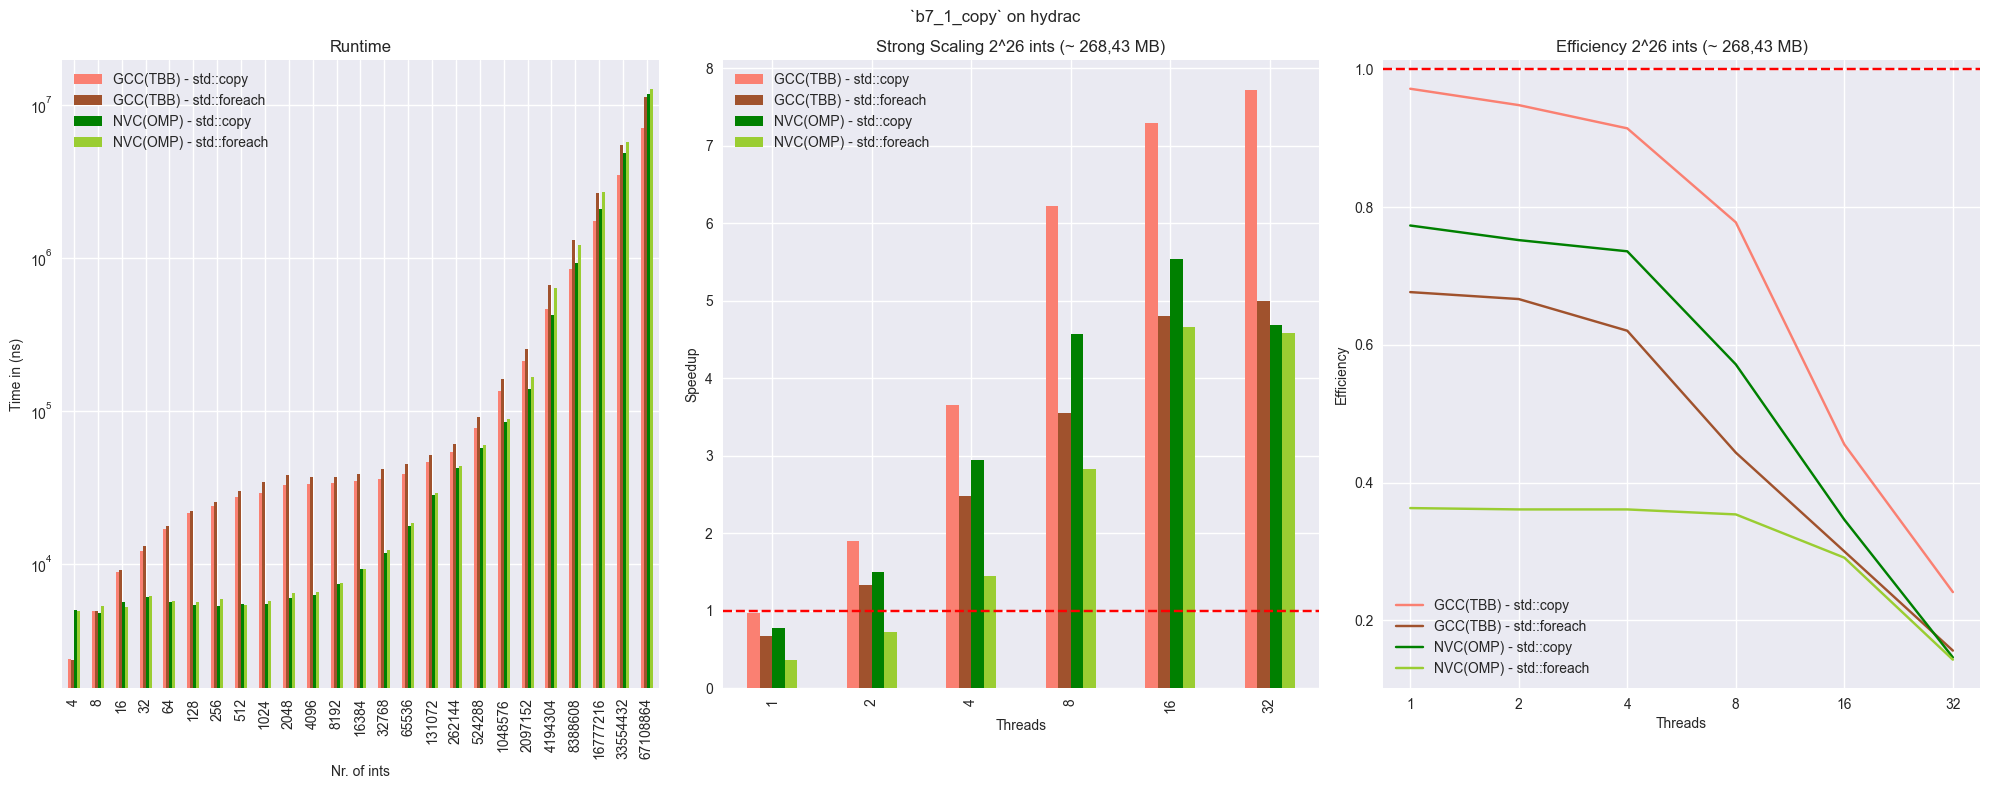

In [121]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_1_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_1_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,2.75)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b7_1_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

#ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_1_copy` on {device_name}")

fig.tight_layout()

plot(f"`b7_1_copy` {device_name}")

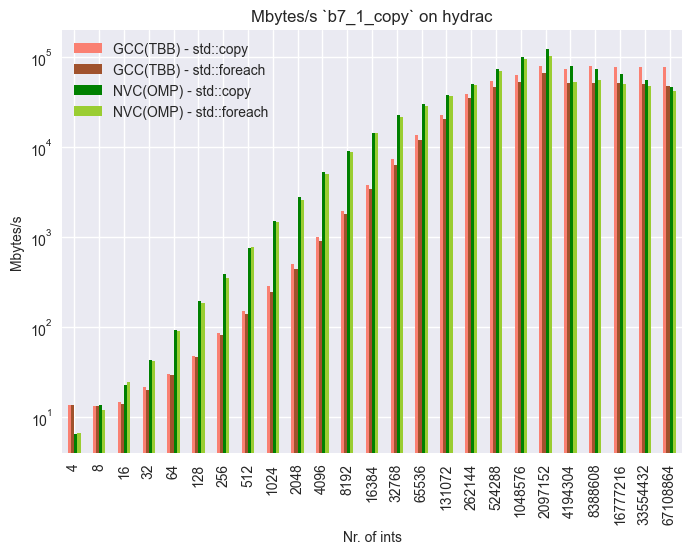

In [122]:
# mybtes graph


b7_1_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                    )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_1_copy` on {device_name}')


plot(f'`b7_1_copy` Mbytes_s on {device_name}')

## `b7_2` -  all_true

In [123]:
benchmark_names = [
    ("b7_2_all_of_all_true",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_all_true",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_all_true'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_true

Check how the runtime without constraining the threads develops with increasing input size

In [124]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_time_merged = pd.merge(b7_2_time_merged,data[i], on='n')

b7_2_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,2203.55,4,1204.03,19505.8,9906.56
1,4725.24,8,2305.47,20441.4,10589.20
2,8587.48,16,4762.22,23838.5,10793.80
3,12035.40,32,8480.31,24520.5,11417.10
4,15976.80,64,12114.10,23600.8,12653.80
5,20218.40,128,17045.70,23811.0,11759.50
6,24041.30,256,20755.20,24289.3,11705.00
7,26748.70,512,23677.50,24723.6,11734.30
8,30056.80,1024,27525.80,25339.8,11772.10
9,33176.20,2048,29768.30,25305.0,11828.90


### Strong Scaling - all true
 
2^26 fixed input size with threads 1-64

In [125]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_strong_scaling_merged = pd.merge(b7_2_strong_scaling_merged,data[i], on='threads')


b7_2_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.799598,0.832121,0.279044,0.685016
1,2,1.605106,1.630741,0.551533,1.345461
2,4,2.882693,3.147011,1.062597,2.639104
3,8,6.047594,6.305871,2.121506,5.084504
4,16,10.542190,11.252070,3.842931,9.963823
5,32,14.081366,14.122808,6.348172,18.655507


In [126]:
## efficiency graph

b7_2_efficiency = b7_2_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_efficiency[f'{compiler_name} - {display_name}'] = b7_2_efficiency[f'{compiler_name} - {display_name}'] / b7_2_efficiency['threads']

b7_2_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.799598,0.832121,0.279044,0.685016
1,2,0.802553,0.815371,0.275767,0.672730
2,4,0.720673,0.786753,0.265649,0.659776
3,8,0.755949,0.788234,0.265188,0.635563
4,16,0.658887,0.703254,0.240183,0.622739
5,32,0.440043,0.441338,0.198380,0.582985


### Mbytes/s

In [127]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_all_true_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_all_true_bytes_merged = pd.merge(b7_2_all_true_bytes_merged,data[i], on='n')

b7_2_all_true_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,7.26102,26.5773,0.820268,3.23018
1,8,6.77214,27.7601,1.565450,6.04390
2,16,7.45271,26.8782,2.684730,11.85870
3,32,10.63530,30.1876,5.220120,22.42250
4,64,16.02320,42.2648,10.847100,40.46220
5,128,25.32350,60.0738,21.502700,87.07840
6,256,42.59340,98.6739,42.158500,174.96800
7,512,76.56460,172.9910,82.835800,349.06200
8,1024,136.27500,297.6120,161.643000,695.88500
9,2048,246.92400,550.3840,323.731000,1385.08000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16668/3600482037.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


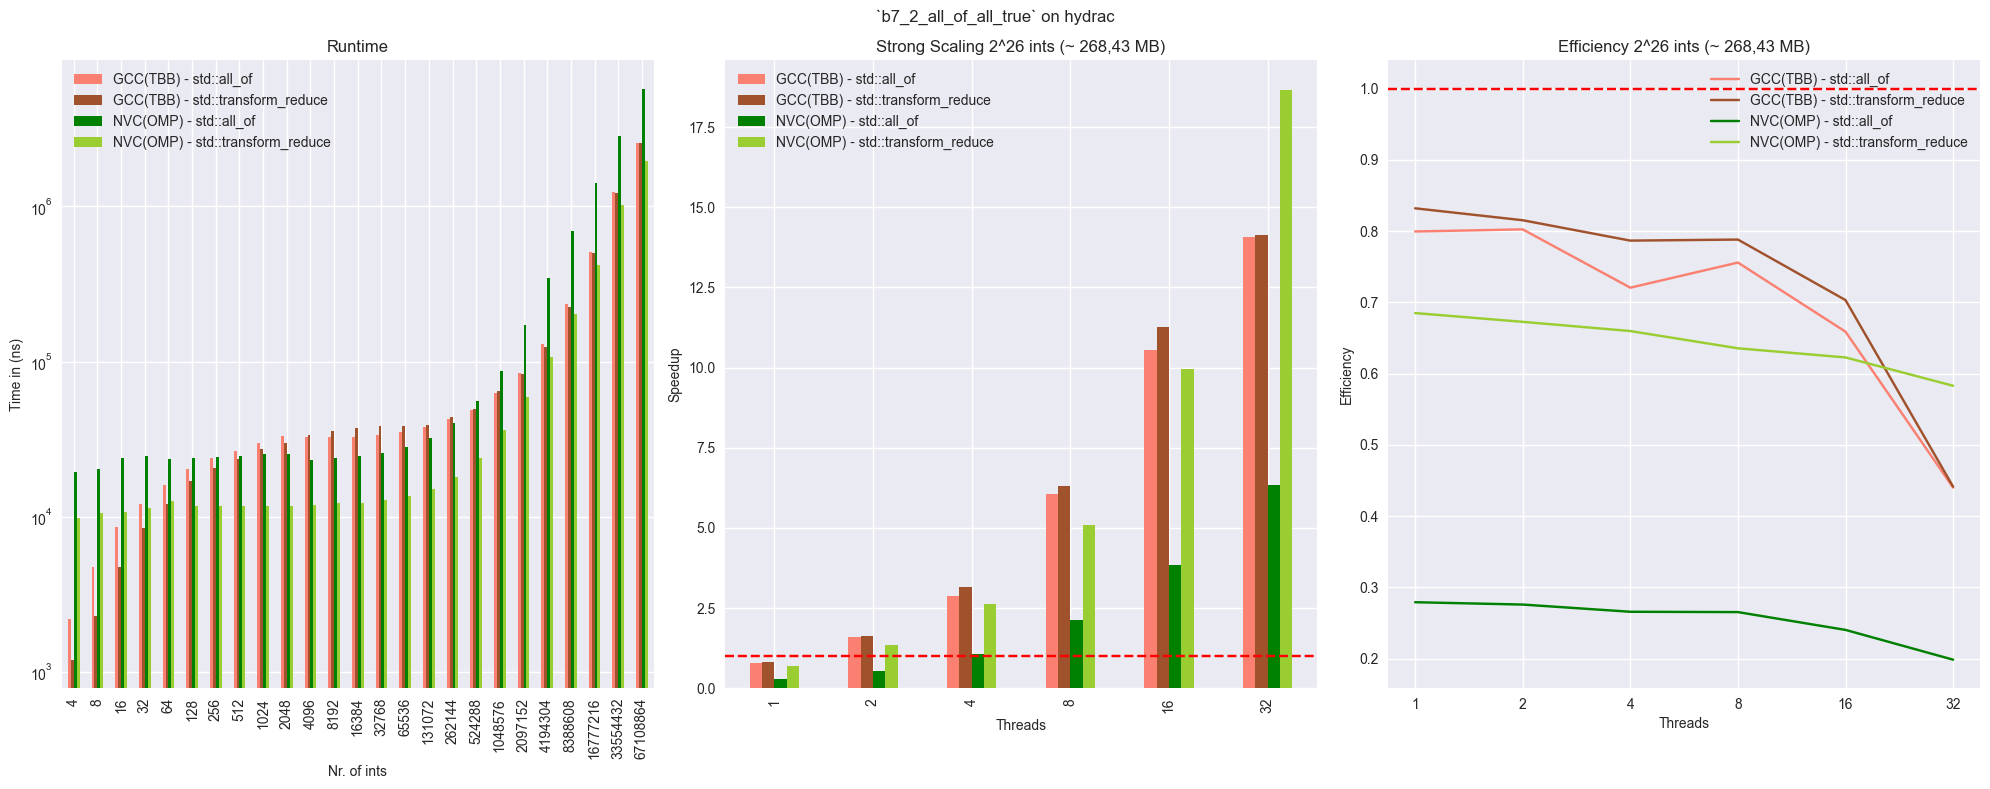

In [128]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
##ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

#ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_all_true` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_all_true` {device_name}")

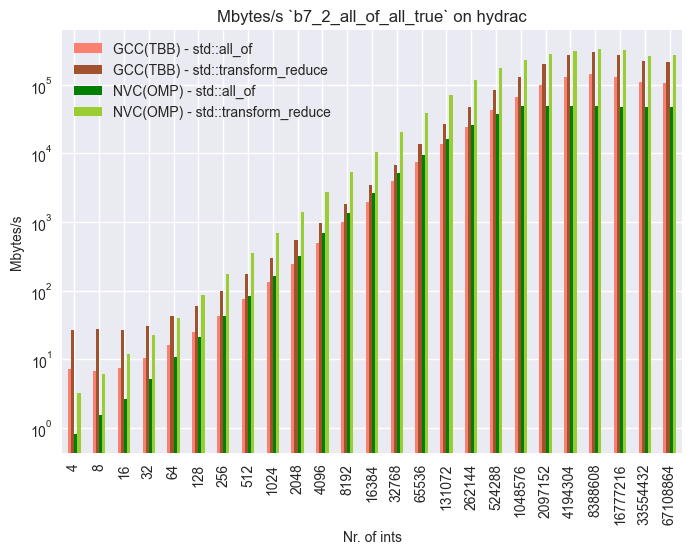

In [129]:
# mybtes graph


b7_2_all_true_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_all_true` on {device_name}')


plot(f'`b7_2_all_of_all_true` Mbytes_s on {device_name}')

## `b7_2` -  first_false

In [130]:
benchmark_names = [
    ("b7_2_all_of_first_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_first_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_first_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - first_false

Check how the runtime without constraining the threads develops with increasing input size

In [131]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_first_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_time_merged = pd.merge(b7_2_first_false_time_merged,data[i], on='n')

b7_2_first_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1767.16,4,1127.76,23071.7,9937.84
1,2701.32,8,2234.74,22190.7,10090.70
2,3822.59,16,4824.77,22604.9,11608.30
3,5007.09,32,8960.62,23480.0,12892.60
4,6074.30,64,13039.20,23836.2,12782.10
5,7575.99,128,17531.80,24186.7,12738.80
6,7826.38,256,20634.90,24351.8,12822.90
7,7373.97,512,23660.80,24430.1,12794.40
8,7611.87,1024,27486.30,23527.6,12786.00
9,7837.44,2048,30938.40,23453.6,12819.10


### Strong Scaling - first_false
 
2^26 fixed input size with threads 1-64

In [132]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_first_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_strong_scaling_merged = pd.merge(b7_2_first_false_strong_scaling_merged,data[i], on='threads')


b7_2_first_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.030182,7.770184e-07,0.000012,3.002851e-07
1,2,0.008989,1.443223e-06,0.000023,5.977984e-07
2,4,0.007611,2.910377e-06,0.000045,1.166984e-06
3,8,0.004261,5.823820e-06,0.000087,2.251155e-06
4,16,0.005670,8.811539e-06,0.000155,4.185012e-06
5,32,0.003901,1.159522e-05,0.000262,7.336713e-06


In [133]:
## efficiency graph

b7_2_first_false_efficiency = b7_2_first_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_first_false_efficiency['threads']

b7_2_first_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.030182,7.770184e-07,0.000012,3.002851e-07
1,2,0.004494,7.216117e-07,0.000012,2.988992e-07
2,4,0.001903,7.275942e-07,0.000011,2.917461e-07
3,8,0.000533,7.279775e-07,0.000011,2.813944e-07
4,16,0.000354,5.507212e-07,0.000010,2.615633e-07
5,32,0.000122,3.623506e-07,0.000008,2.292723e-07


### Mbytes/s

In [134]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_first_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_bytes_merged = pd.merge(b7_2_first_false_bytes_merged,data[i], on='n')

b7_2_first_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,9.054090e+00,28.3748,6.934890e-01,3.22002
1,8,1.184600e+01,28.6387,1.442040e+00,6.34244
2,16,1.674260e+01,26.5298,2.831250e+00,11.02660
3,32,2.556380e+01,28.5694,5.451450e+00,19.85640
4,64,4.214480e+01,39.2661,1.073990e+01,40.05610
5,128,6.758200e+01,58.4081,2.116870e+01,80.38460
6,256,1.308390e+02,99.2496,4.205040e+01,159.71500
7,512,2.777340e+02,173.1130,8.383090e+01,320.14000
8,1024,5.381070e+02,298.0390,1.740930e+02,640.70100
9,2048,1.045240e+03,529.5690,3.492850e+02,1278.10000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16668/1392981099.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


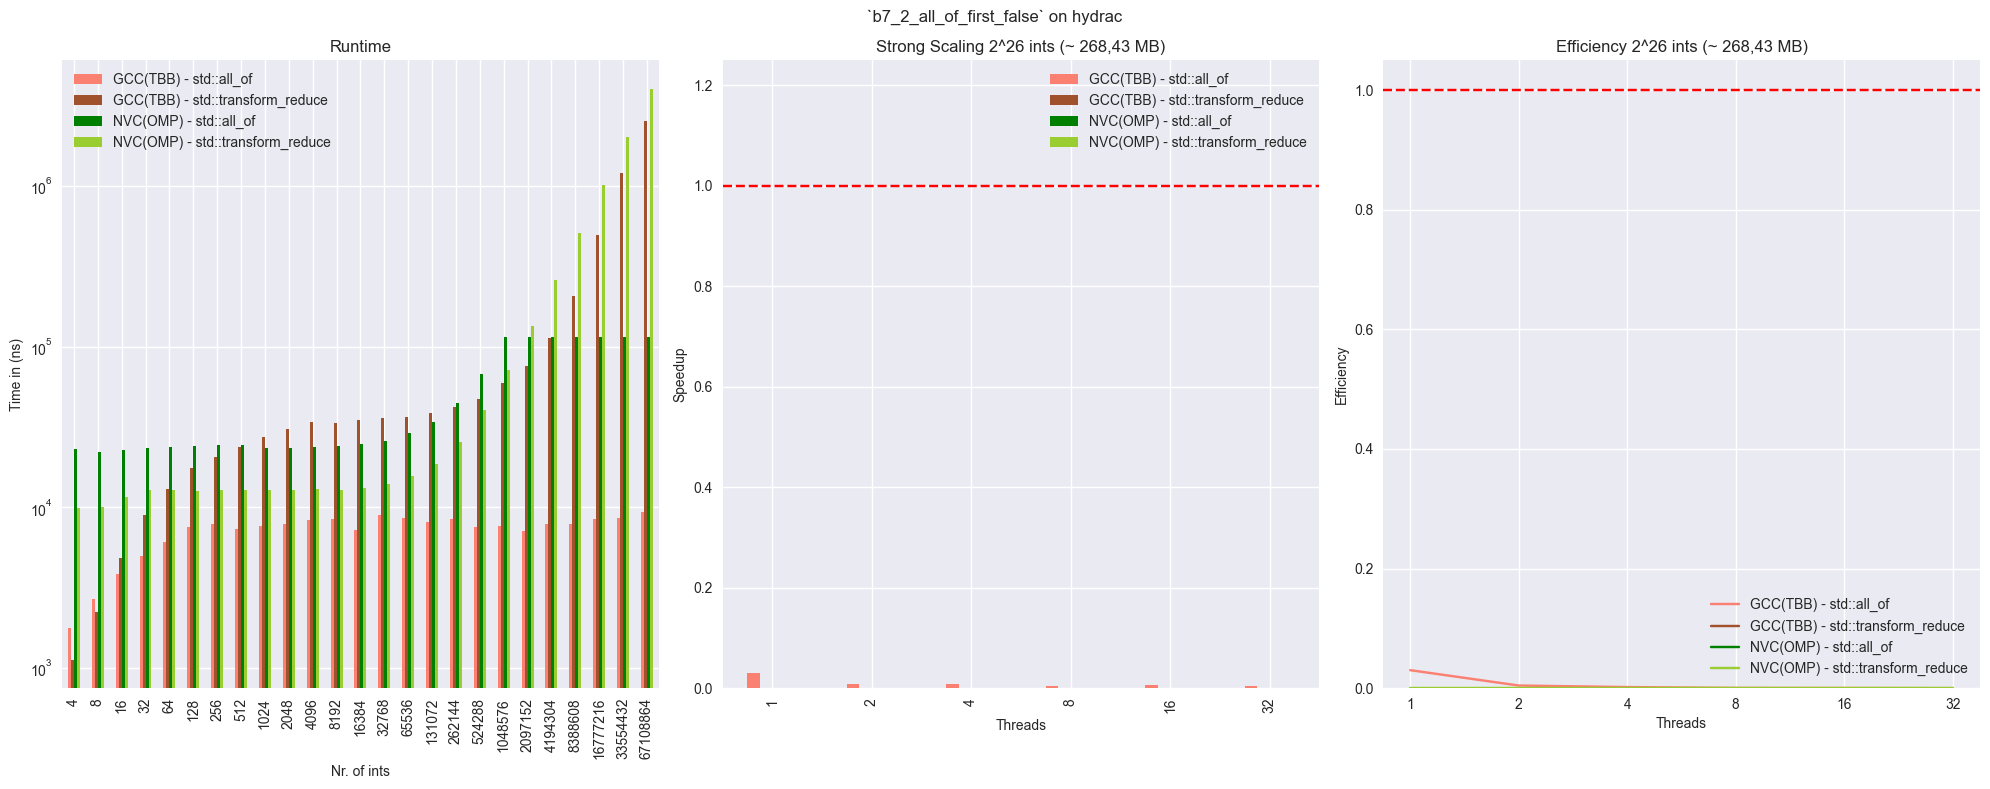

In [135]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_first_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_first_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,1.25)





# plot efficiency
ax_3 = b7_2_first_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_first_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_first_false` {device_name}")

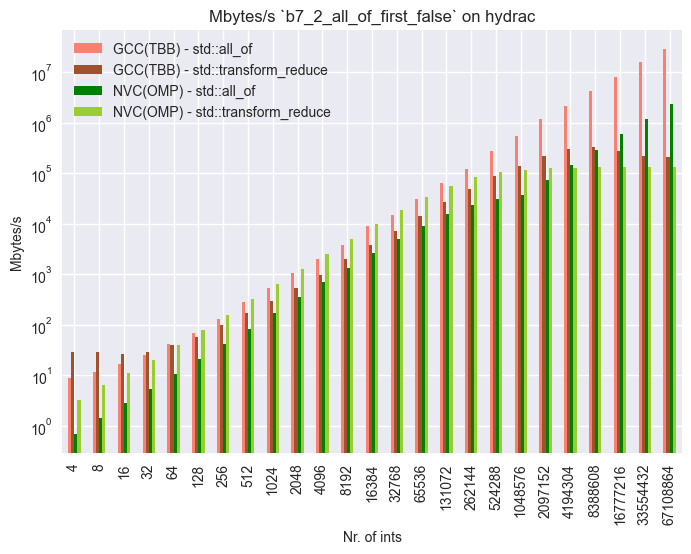

In [136]:

# mybtes graph


b7_2_first_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_first_false` on {device_name}')


plot(f'`b7_2_all_of_first_false` Mbytes_s on {device_name}')

## `b7_2` -  last_false

In [137]:
benchmark_names = [
    ("b7_2_all_of_last_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_last_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_last_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - last_false

Check how the runtime without constraining the threads develops with increasing input size

In [138]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_last_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_time_merged = pd.merge(b7_2_last_false_time_merged,data[i], on='n')

b7_2_last_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,2275.78,4,1213.73,20256.2,9664.15
1,4708.24,8,2340.57,21121.3,9983.44
2,8228.59,16,4848.79,22525.8,10130.20
3,12667.50,32,8703.26,22815.5,11542.40
4,15842.80,64,12634.60,22760.9,11604.70
5,19727.70,128,16050.10,22635.0,12053.80
6,22053.20,256,20671.00,22781.9,12743.20
7,24355.50,512,23839.60,22706.4,12721.30
8,26622.40,1024,27672.50,22872.2,12768.50
9,28991.80,2048,30394.00,22985.5,12833.90


### Strong Scaling - last_false
 
2^26 fixed input size with threads 1-64

In [139]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_last_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_strong_scaling_merged = pd.merge(b7_2_last_false_strong_scaling_merged,data[i], on='threads')


b7_2_last_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.985908,0.921662,0.234961,0.387283
1,2,1.900776,1.770340,0.465028,0.775260
2,4,3.843913,3.468245,0.906117,1.548292
3,8,8.224396,7.051509,1.804832,3.102324
4,16,13.670259,11.836763,3.311556,6.164068
5,32,17.495802,14.790168,5.780674,12.071017


In [140]:
## efficiency graph

b7_2_last_false_efficiency = b7_2_last_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_last_false_efficiency['threads']

b7_2_last_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.985908,0.921662,0.234961,0.387283
1,2,0.950388,0.885170,0.232514,0.387630
2,4,0.960978,0.867061,0.226529,0.387073
3,8,1.028050,0.881439,0.225604,0.387790
4,16,0.854391,0.739798,0.206972,0.385254
5,32,0.546744,0.462193,0.180646,0.377219


### Mbytes/s

In [141]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_last_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_bytes_merged = pd.merge(b7_2_last_false_bytes_merged,data[i], on='n')

b7_2_last_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,7.03056,26.3649,0.789883,3.31121
1,8,6.79660,27.3438,1.515060,6.41061
2,16,7.77776,26.3983,2.841190,12.63550
3,32,10.10460,29.4143,5.610220,22.17910
4,64,16.15870,40.5237,11.247400,44.12020
5,128,25.95330,63.8003,22.619800,84.95240
6,256,46.43320,99.0759,44.948000,160.71300
7,512,84.08780,171.8150,90.194700,321.98100
8,1024,153.85500,296.0340,179.082000,641.58100
9,2048,282.56300,539.0540,356.399000,1276.62000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16668/3655766821.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


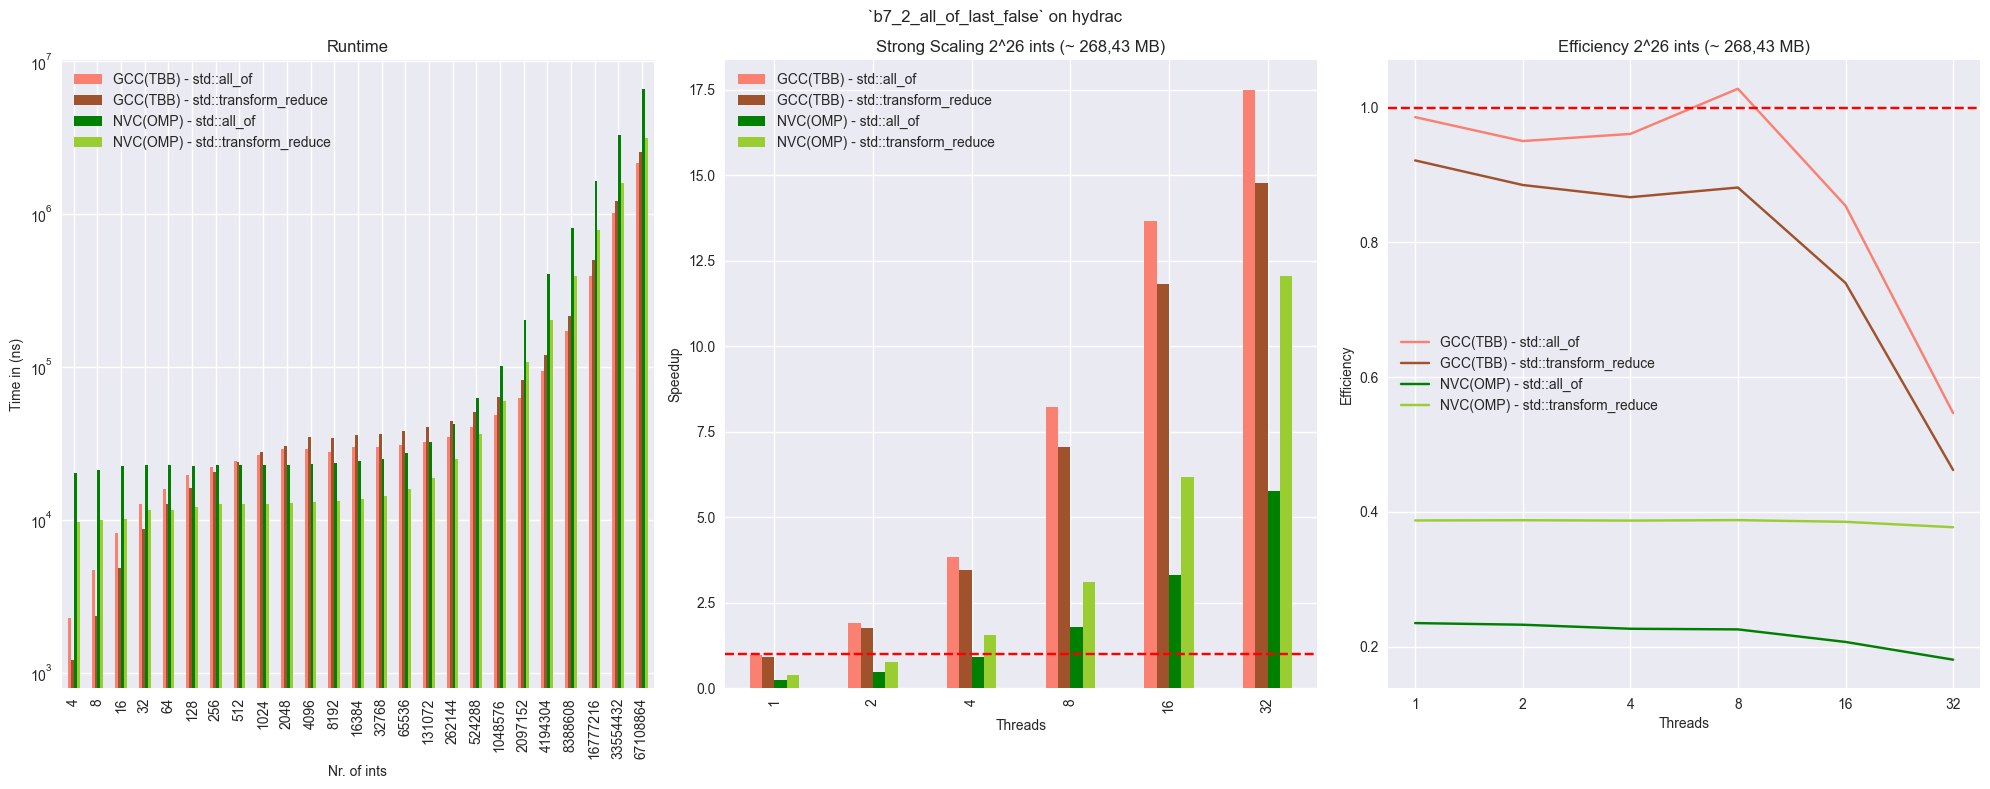

In [142]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_last_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_last_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
#ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_last_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

#ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_last_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_last_false` {device_name}")

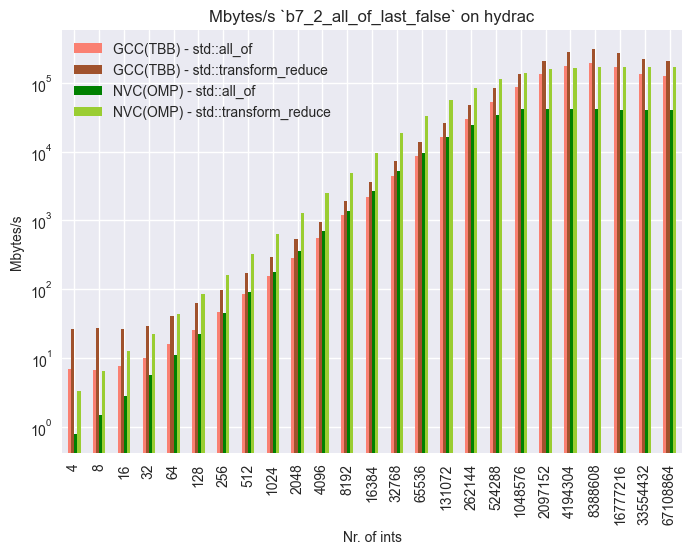

In [143]:
b7_2_last_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_last_false` on {device_name}')


plot(f'`b7_2_all_of_last_false` Mbytes_s on {device_name}')

## `b7_2` -  auto_false

In [144]:
benchmark_names = [
    ("b7_2_all_of_auto_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_auto_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_auto_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - auto_false

Check how the runtime without constraining the threads develops with increasing input size

In [145]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_auto_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_time_merged = pd.merge(b7_2_auto_false_time_merged,data[i], on='n')

b7_2_auto_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1828.00,4,1187.11,19312.8,9918.42
1,2949.85,8,2292.78,20738.3,11415.50
2,4071.43,16,4722.32,22039.0,11577.20
3,5178.13,32,8673.61,22710.4,12806.10
4,6334.97,64,12726.70,23098.0,12984.30
5,7742.00,128,16564.40,23314.8,12541.50
6,7686.59,256,19975.00,23415.0,12550.50
7,7919.01,512,22433.60,23338.6,12608.60
8,7917.45,1024,26031.20,23548.3,12333.40
9,7953.92,2048,28684.10,23888.7,12340.40


### Strong Scaling - auto_false
 
2^26 fixed input size with threads 1-64

In [146]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_auto_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_strong_scaling_merged = pd.merge(b7_2_auto_false_strong_scaling_merged,data[i], on='threads')


b7_2_auto_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.028916,0.000002,0.000227,0.039573
1,2,0.012282,0.000004,0.000407,0.007576
2,4,0.011715,0.000007,0.000725,0.006656
3,8,0.007467,0.000014,0.000874,0.003936
4,16,0.007858,0.000027,0.000970,0.003419
5,32,0.004165,0.000051,0.001192,0.002656


In [147]:
## efficiency graph

b7_2_auto_false_efficiency = b7_2_auto_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_auto_false_efficiency['threads']

b7_2_auto_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.028916,0.000002,0.000227,0.039573
1,2,0.006141,0.000002,0.000203,0.003788
2,4,0.002929,0.000002,0.000181,0.001664
3,8,0.000933,0.000002,0.000109,0.000492
4,16,0.000491,0.000002,0.000061,0.000214
5,32,0.000130,0.000002,0.000037,0.000083


### Mbytes/s

In [148]:
# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_auto_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_bytes_merged = pd.merge(b7_2_auto_false_bytes_merged,data[i], on='n')

b7_2_auto_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,8.752740e+00,26.9561,8.284670e-01,3.226320e+00
1,8,1.084800e+01,27.9137,1.543040e+00,5.606430e+00
2,16,1.571930e+01,27.1053,2.903950e+00,1.105620e+01
3,32,2.471930e+01,29.5148,5.636190e+00,1.999050e+01
4,64,4.041060e+01,40.2305,1.108320e+01,3.943210e+01
5,128,6.613280e+01,61.8194,2.196030e+01,8.164880e+01
6,256,1.332190e+02,102.5280,4.373260e+01,1.631810e+02
7,512,2.586180e+02,182.5840,8.775180e+01,3.248570e+02
8,1024,5.173380e+02,314.6990,1.739400e+02,6.642110e+02
9,2048,1.029930e+03,571.1870,3.429230e+02,1.327680e+03


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16668/1629545763.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


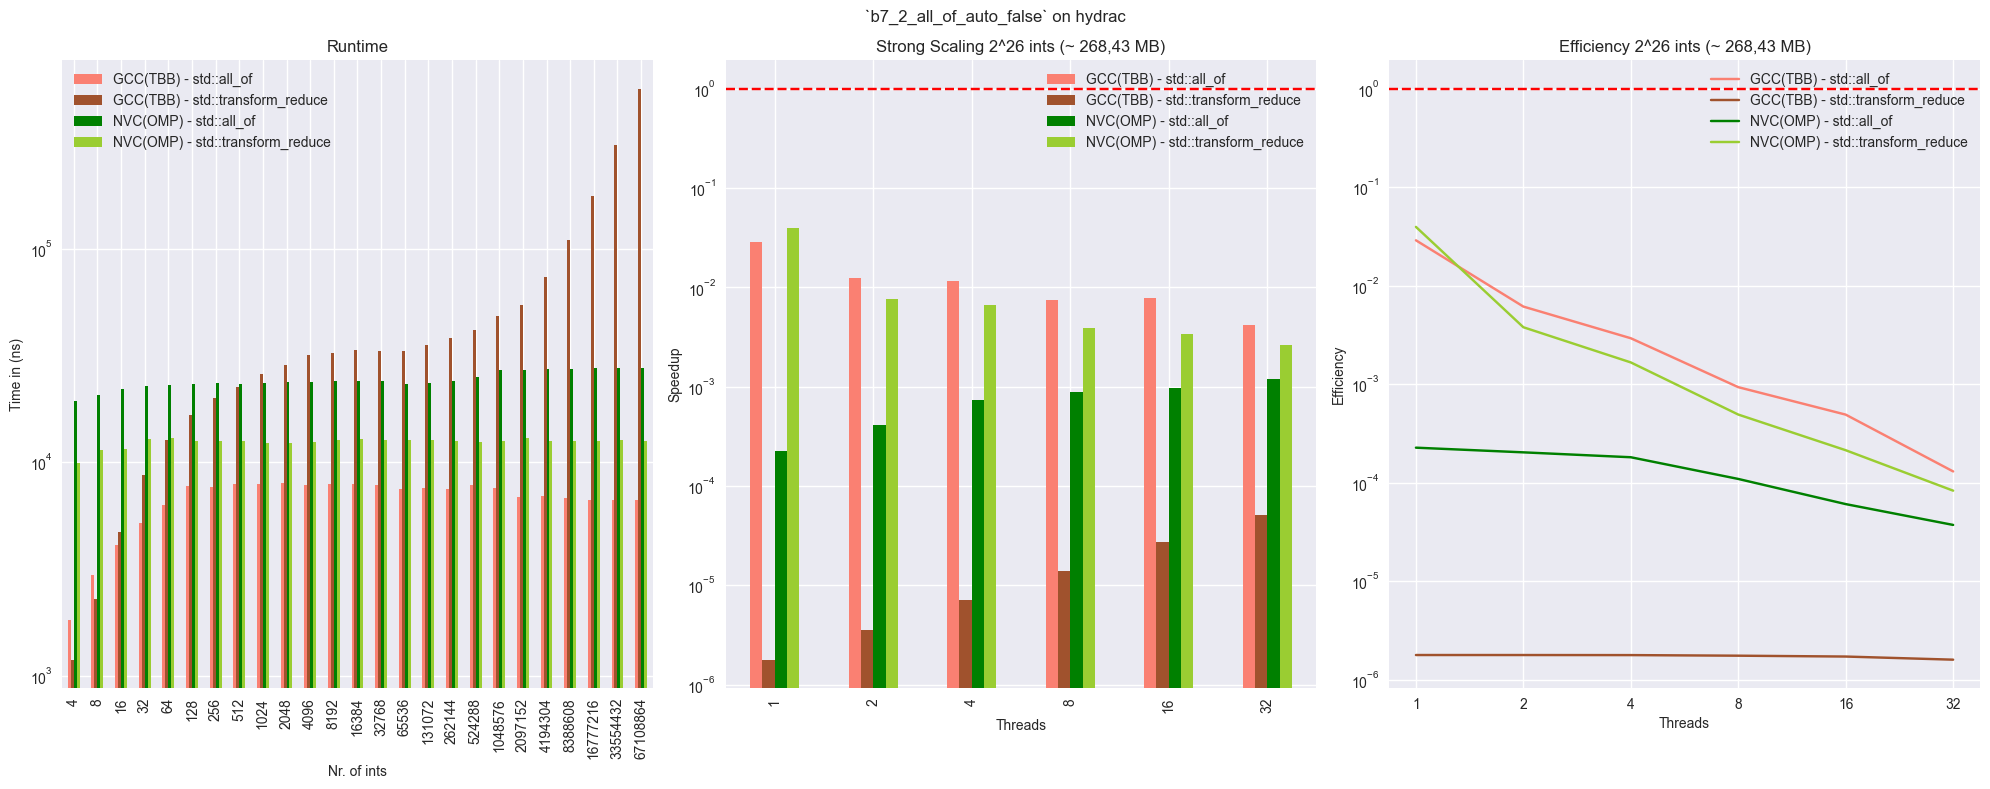

In [149]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_auto_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_auto_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')



# plot efficiency
ax_3 = b7_2_auto_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_yscale('log',base=10)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_auto_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_auto_false` {device_name}")

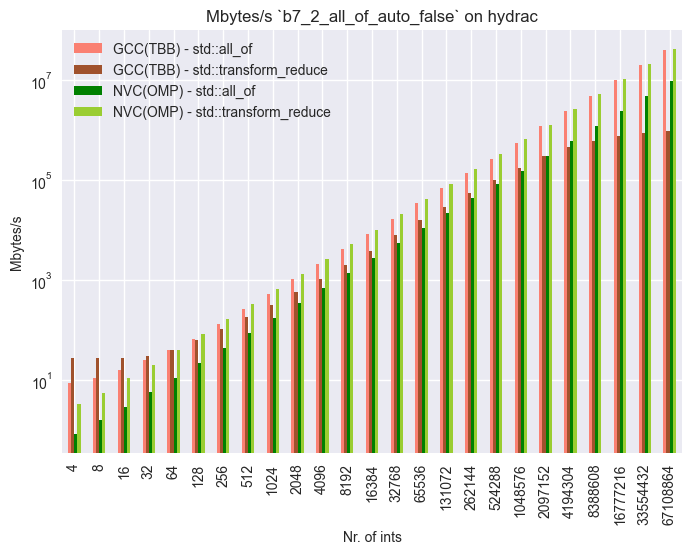

In [150]:

# mybtes graph

b7_2_auto_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_auto_false` on {device_name}')


plot(f'`b7_2_all_of_auto_false` Mbytes_s on {device_name}')

## `b7_3` -  all_hit

In [151]:
benchmark_names = [
    ("b7_3_count_if_all_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_all_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_all_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_all_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_hit

Check how the runtime without constraining the threads develops with increasing input size

In [152]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_all_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_time_merged = pd.merge(b7_3_all_hit_time_merged,data[i], on='n')

b7_3_all_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,2311.90,4,1174.27,9565.07,9916.34
1,4904.51,8,2278.05,9812.79,11098.60
2,8604.58,16,4799.93,11252.80,10899.40
3,12776.60,32,8899.05,11468.70,12135.90
4,15763.00,64,13276.60,11215.90,11710.50
5,20221.50,128,16299.00,11476.60,11974.10
6,23569.80,256,20471.60,11558.90,12756.90
7,26879.70,512,24367.80,11974.80,12805.70
8,31834.40,1024,27706.10,11677.50,12860.80
9,34720.50,2048,29876.50,11590.80,11994.00


### Strong Scaling - all_hit
 
2^26 fixed input size with threads 1-64

In [153]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_all_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_strong_scaling_merged = pd.merge(b7_3_all_hit_strong_scaling_merged,data[i], on='threads')


b7_3_all_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.008900,0.600978,1.170112,1.299900
1,2,2.078326,1.195996,2.228051,2.406867
2,4,3.869289,2.182523,4.466543,4.772143
3,8,6.096486,4.525038,8.712907,8.787585
4,16,9.028350,8.100350,14.371022,14.207317
5,32,10.879109,10.894707,21.977272,21.605411


In [154]:
## efficiency graph

b7_3_all_hit_efficiency = b7_3_all_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_all_hit_efficiency['threads']

b7_3_all_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.008900,0.600978,1.170112,1.299900
1,2,1.039163,0.597998,1.114025,1.203433
2,4,0.967322,0.545631,1.116636,1.193036
3,8,0.762061,0.565630,1.089113,1.098448
4,16,0.564272,0.506272,0.898189,0.887957
5,32,0.339972,0.340460,0.686790,0.675169


### Mbytes/s

In [155]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_all_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_bytes_merged = pd.merge(b7_3_all_hit_bytes_merged,data[i], on='n')

b7_3_all_hit_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,6.92072,13.6255,1.67275,1.61350
1,8,6.52461,14.0471,3.26105,2.88326
2,16,7.43790,13.3335,5.68749,5.87190
3,32,10.01830,14.3836,11.16080,10.54720
4,64,16.24060,19.2821,22.82480,21.86080
5,128,25.31960,31.4129,44.61260,42.75910
6,256,43.44550,50.0206,88.58960,80.27040
7,512,76.19130,84.0453,171.02500,159.92900
8,1024,128.66600,147.8370,350.75900,318.48700
9,2048,235.94100,274.1960,706.76900,683.01100


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16668/3164471847.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


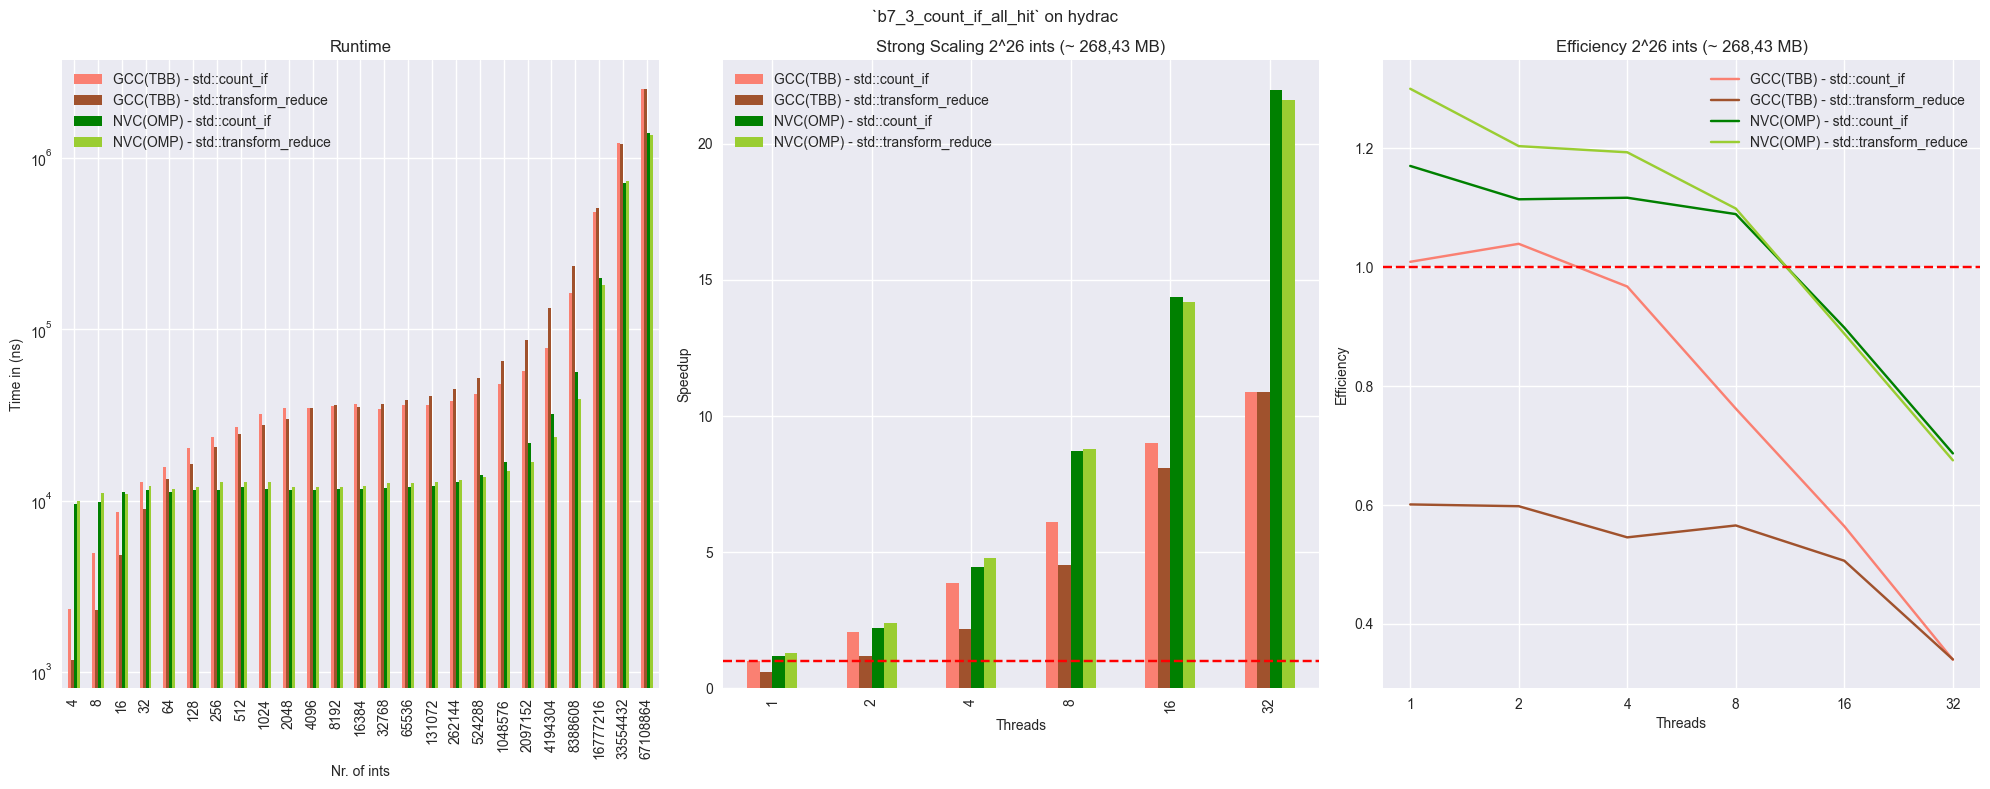

In [156]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_all_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_all_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_all_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')

fig.suptitle(f"`b7_3_count_if_all_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_all_hit` {device_name}")

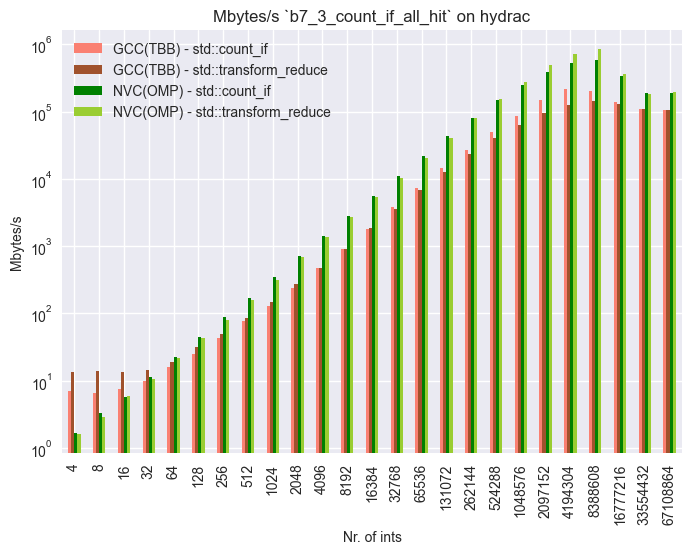

In [157]:
# mybtes graph

b7_3_all_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_all_hit` on {device_name}')


plot(f'`b7_3_count_if_all_hit` Mbytes_s on {device_name}')

## `b7_3` -  half_hit

In [158]:
benchmark_names = [
    ("b7_3_count_if_half_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_half_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_half_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_half_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - half_hit

Check how the runtime without constraining the threads develops with increasing input size

In [159]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_half_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_time_merged = pd.merge(b7_3_half_hit_time_merged,data[i], on='n')

b7_3_half_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,2328.07,4,1109.34,9426.91,10103.1
1,5107.63,8,2372.50,10433.40,10403.9
2,9623.63,16,4879.96,10348.00,10494.0
3,13853.60,32,9150.61,11124.20,11715.6
4,18532.30,64,12948.20,10881.60,11756.7
5,23407.60,128,16450.30,11088.70,11707.8
6,28010.60,256,20673.00,11082.70,11673.2
7,31308.30,512,23806.20,11146.60,11774.8
8,35760.70,1024,27892.50,11187.60,11863.7
9,39384.90,2048,30968.70,11205.90,11785.6


### Strong Scaling - half_hit
 
2^26 fixed input size with threads 1-64

In [160]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_half_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_strong_scaling_merged = pd.merge(b7_3_half_hit_strong_scaling_merged,data[i], on='threads')


b7_3_half_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.850291,0.505796,0.982319,1.102315
1,2,1.642602,0.991033,1.965610,2.068819
2,4,2.664598,1.802267,3.587847,3.953794
3,8,5.446929,3.795610,7.002690,7.485763
4,16,7.786433,6.828137,10.794721,11.586397
5,32,9.173701,9.095955,17.680129,18.387107


In [161]:
## efficiency graph

b7_3_half_hit_efficiency = b7_3_half_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_half_hit_efficiency['threads']

b7_3_half_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.850291,0.505796,0.982319,1.102315
1,2,0.821301,0.495516,0.982805,1.034410
2,4,0.666149,0.450567,0.896962,0.988449
3,8,0.680866,0.474451,0.875336,0.935720
4,16,0.486652,0.426759,0.674670,0.724150
5,32,0.286678,0.284249,0.552504,0.574597


### Mybtes/s

In [162]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_half_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_bytes_merged = pd.merge(b7_3_half_hit_bytes_merged,data[i], on='n')

b7_3_half_hit_bytes_merged


,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,6.87263,14.4230,1.69727,1.58367
1,8,6.26514,13.4879,3.06708,3.07578
2,16,6.65030,13.1149,6.18479,6.09873
3,32,9.23946,13.9881,11.50640,10.92560
4,64,13.81370,19.7711,23.52600,21.77480
5,128,21.87330,31.1241,46.17330,43.73160
6,256,36.55760,49.5333,92.39610,87.72230
7,512,65.41400,86.0282,183.73300,173.93100
8,1024,114.53900,146.8500,366.12100,345.25600
9,2048,207.99800,264.5250,731.04400,695.08400


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16668/4180608575.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


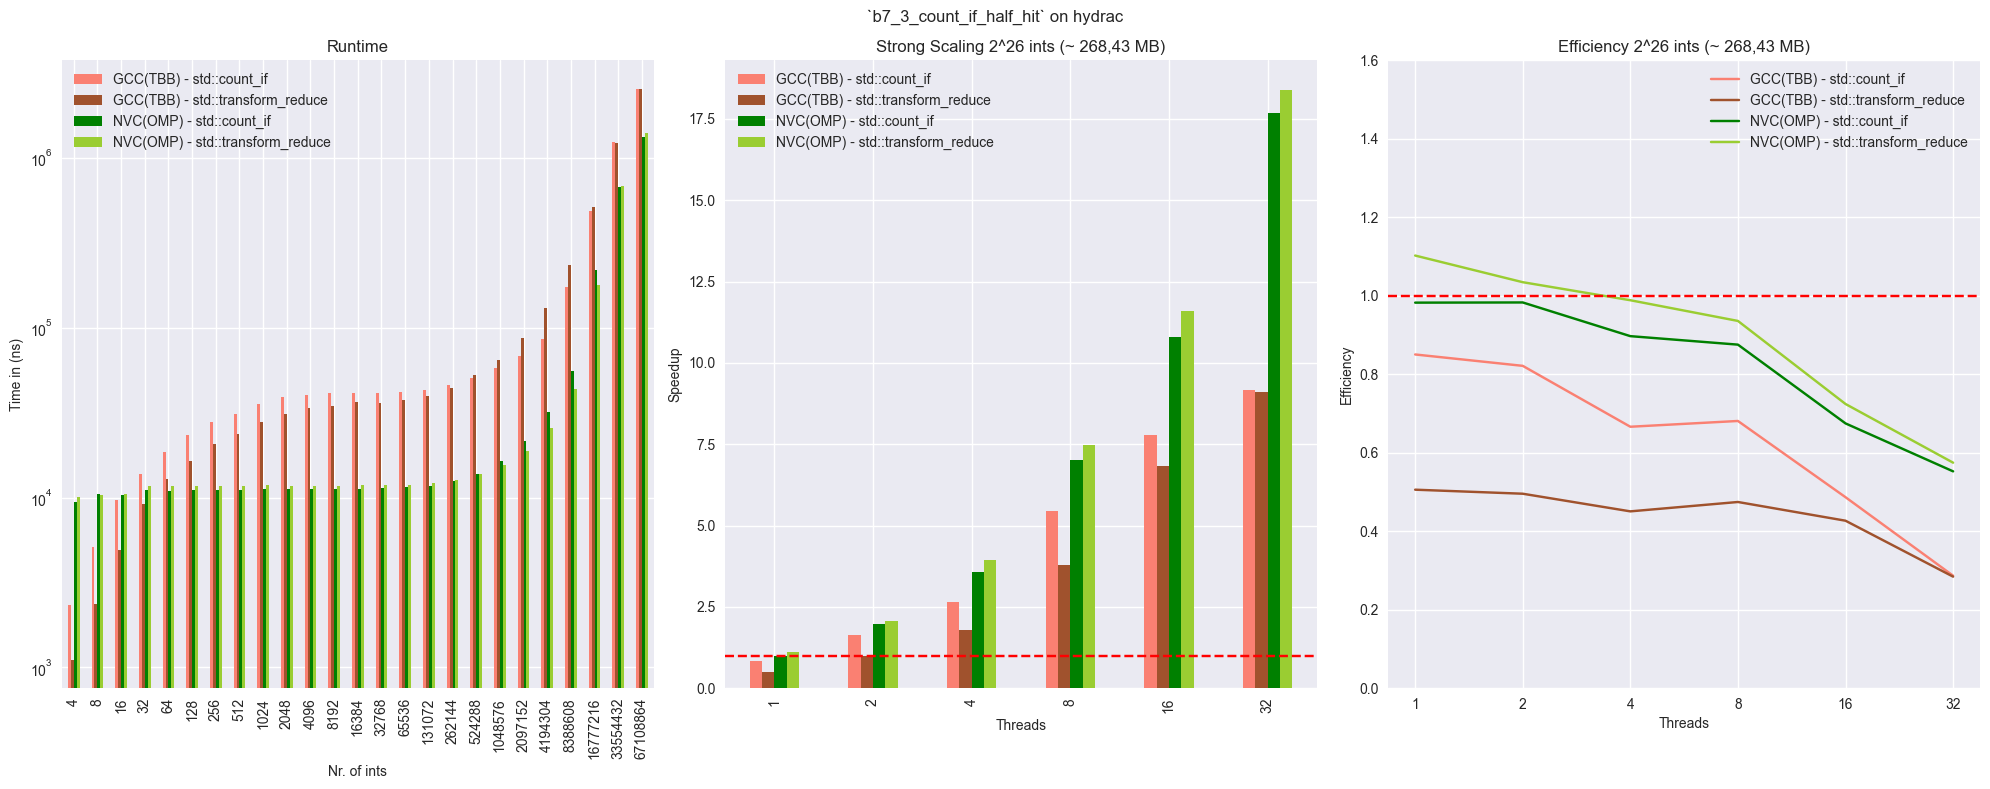

In [163]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_half_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_half_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_half_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')
ax_3.set_ylim(0,1.6)


fig.suptitle(f"`b7_3_count_if_half_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_half_hit` {device_name}")

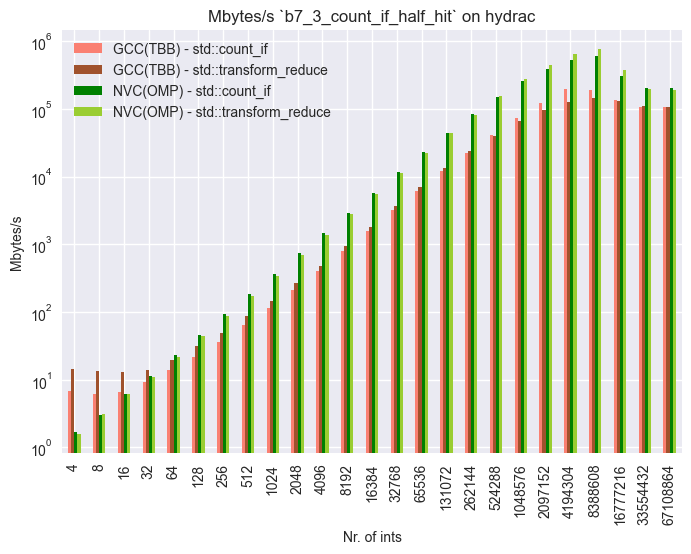

In [164]:
# mybtes graph

b7_3_half_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_half_hit` Mbytes_s on {device_name}')

## `b7_3` -  orders_struct

In [165]:
benchmark_names = [
    ("b7_3_count_if_orders_struct",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_orders_struct",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_orders_struct",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_orders_struct'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - orders_struct

Check how the runtime without constraining the threads develops with increasing input size

In [166]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_orders_struct_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_time_merged = pd.merge(b7_3_orders_struct_time_merged,data[i], on='n')

b7_3_orders_struct_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,2438.14,4,1186.18,10403.1,9918.17
1,5103.88,8,2296.48,10410.4,9969.54
2,8840.80,16,4845.95,10476.8,11415.20
3,12981.50,32,8798.22,11737.6,11813.50
4,16438.50,64,13247.80,12025.5,11505.50
5,20838.20,128,17108.10,12737.1,11839.30
6,24378.20,256,20217.50,12631.9,11737.70
7,27321.70,512,24423.60,12718.8,11930.50
8,30030.20,1024,27404.70,12671.4,12052.40
9,34385.00,2048,29941.90,12684.6,12076.10


### Strong Scaling - orders_struct
 
2^26 fixed input size with threads 1-64

In [167]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_orders_struct_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_strong_scaling_merged = pd.merge(b7_3_orders_struct_strong_scaling_merged,data[i], on='threads')


b7_3_orders_struct_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.958638,0.674997,1.026757,1.180194
1,2,1.935931,1.356557,1.966344,2.204563
2,4,3.742959,2.526619,3.790247,4.470010
3,8,7.341878,5.033501,7.647626,8.355352
4,16,8.511637,7.815695,14.390561,13.128984
5,32,10.465708,10.415059,21.101314,21.110872


In [168]:
## efficiency graph

b7_3_orders_struct_efficiency = b7_3_orders_struct_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] = b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] / b7_3_orders_struct_efficiency['threads']

b7_3_orders_struct_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.958638,0.674997,1.026757,1.180194
1,2,0.967966,0.678279,0.983172,1.102282
2,4,0.935740,0.631655,0.947562,1.117502
3,8,0.917735,0.629188,0.955953,1.044419
4,16,0.531977,0.488481,0.899410,0.820562
5,32,0.327053,0.325471,0.659416,0.659715


### Mbytes/s

In [169]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_orders_struct_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_bytes_merged = pd.merge(b7_3_orders_struct_bytes_merged,data[i], on='n')

b7_3_orders_struct_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,13.1248,26.9774,3.07602,3.22640
1,8,12.5395,27.8688,6.14773,6.41955
2,16,14.4783,26.4138,12.21750,11.21310
3,32,19.7204,29.0968,21.81020,21.67020
4,64,31.1464,38.6480,42.57610,44.50050
5,128,49.1406,59.8548,80.39510,86.49190
6,256,84.0096,101.2990,162.13000,174.48000
7,512,149.9170,167.7060,322.04200,343.32000
8,1024,272.7920,298.9270,646.49500,679.70100
9,2048,476.4870,547.1940,1291.64000,1356.73000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16668/2492568009.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


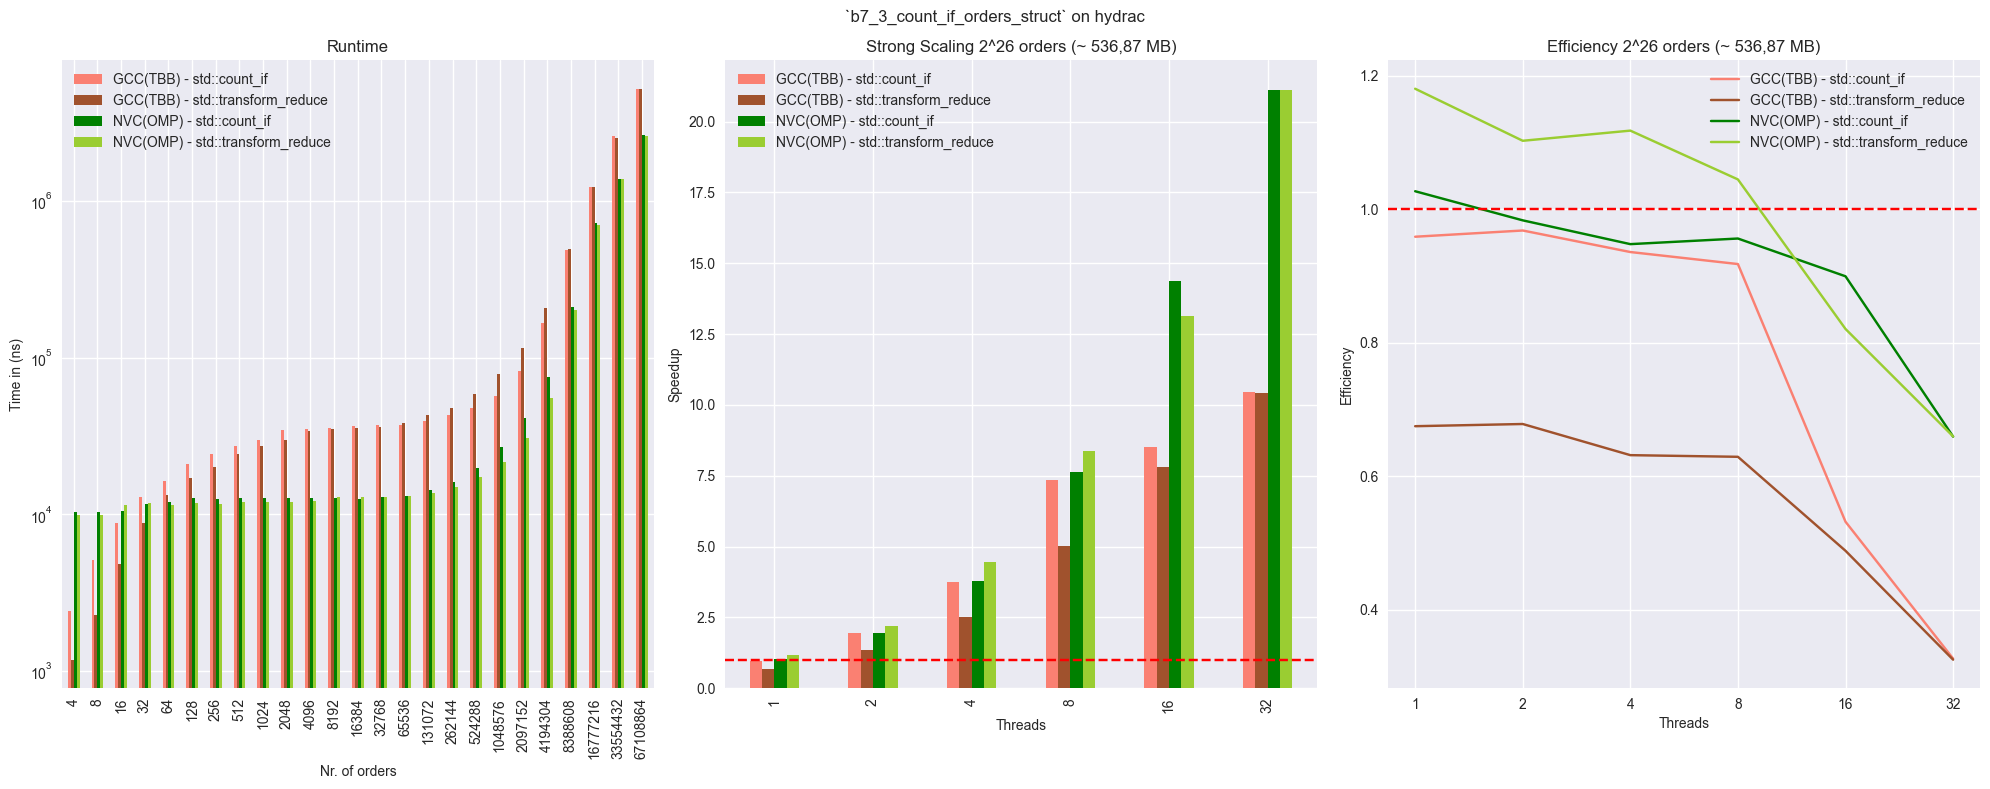

In [170]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_orders_struct_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of orders')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_orders_struct_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 orders (~ 536,87 MB)')





# plot efficiency
ax_3 = b7_3_orders_struct_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 orders (~ 536,87 MB)')


fig.suptitle(f"`b7_3_count_if_orders_struct` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_orders_struct` {device_name}")

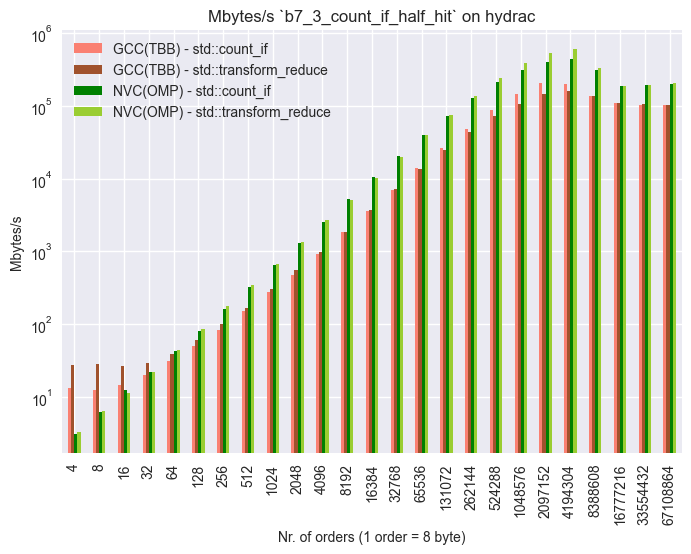

In [171]:
# mybtes graph

b7_3_orders_struct_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of orders (1 order = 8 byte)')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_orders_struct` Mbytes_s on {device_name}')

## `b7_4` - stencil transform 

In [172]:
benchmark_names = [
    ("b7_4_stencil_transform_number_to_neightbours_stdev",'std::transform'),
    ("b7_4_stencil_for_each_to_neightbours_stdev",'std::for_each')
]

strong_scale_base = 'b7_4_stencil_transform_number_to_neightbours_stdev'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [173]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_4_stencil_time_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_time_merged = pd.merge(b7_4_stencil_time_merged,data[i], on='n')

b7_4_stencil_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1190.79,4,1208.68,4804.15,5127.49
1,3712.28,8,3653.76,4710.30,5412.93
2,8652.98,16,8332.77,4568.00,5324.46
3,13407.90,32,12984.10,5506.68,5894.57
4,17300.90,64,16392.60,4751.50,6032.74
5,21720.50,128,21252.90,5201.12,6201.51
6,24808.90,256,24474.70,4960.61,6226.20
7,28378.30,512,29078.30,5726.60,6058.17
8,30468.60,1024,32485.60,5689.04,6278.11
9,33502.60,2048,35834.50,5576.29,6594.12


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [174]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_4_stencil_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_strong_scaling_merged = pd.merge(b7_4_stencil_strong_scaling_merged,data[i], on='threads')


b7_4_stencil_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.147254,0.145886,0.991254,0.552540
1,2,0.294901,0.292220,2.076465,1.096723
2,4,0.588731,0.584423,4.160334,2.106702
3,8,1.176367,1.165910,4.117440,3.602982
4,16,2.333026,2.319964,5.872549,6.000700
5,32,3.332602,3.316793,6.775624,5.522888


In [175]:
## efficiency graph

b7_4_stencil_efficiency = b7_4_stencil_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] = b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] / b7_4_stencil_efficiency['threads']

b7_4_stencil_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.147254,0.145886,0.991254,0.552540
1,2,0.147450,0.146110,1.038233,0.548362
2,4,0.147183,0.146106,1.040084,0.526676
3,8,0.147046,0.145739,0.514680,0.450373
4,16,0.145814,0.144998,0.367034,0.375044
5,32,0.104144,0.103650,0.211738,0.172590


### Mbytes/s

In [176]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_4_stencil_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_bytes_merged = pd.merge(b7_4_stencil_bytes_merged,data[i], on='n')

b7_4_stencil_bytes_merged


,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,50.3868,49.6410,12.4892,11.7016
1,8,33.4026,33.9376,26.3253,22.9081
2,16,29.1229,30.2420,55.1664,47.3288
3,32,37.8881,39.1249,92.2516,86.1810
4,64,58.9564,62.2233,214.6690,169.0770
5,128,94.1046,96.1751,392.9920,329.5970
6,256,164.9410,167.1930,824.8990,657.2220
7,512,288.5300,281.5850,1429.8200,1351.5600
8,1024,537.6020,504.2240,2879.2200,2609.0700
9,2048,977.9530,914.3160,5875.6000,4968.6700


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16668/1698835649.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


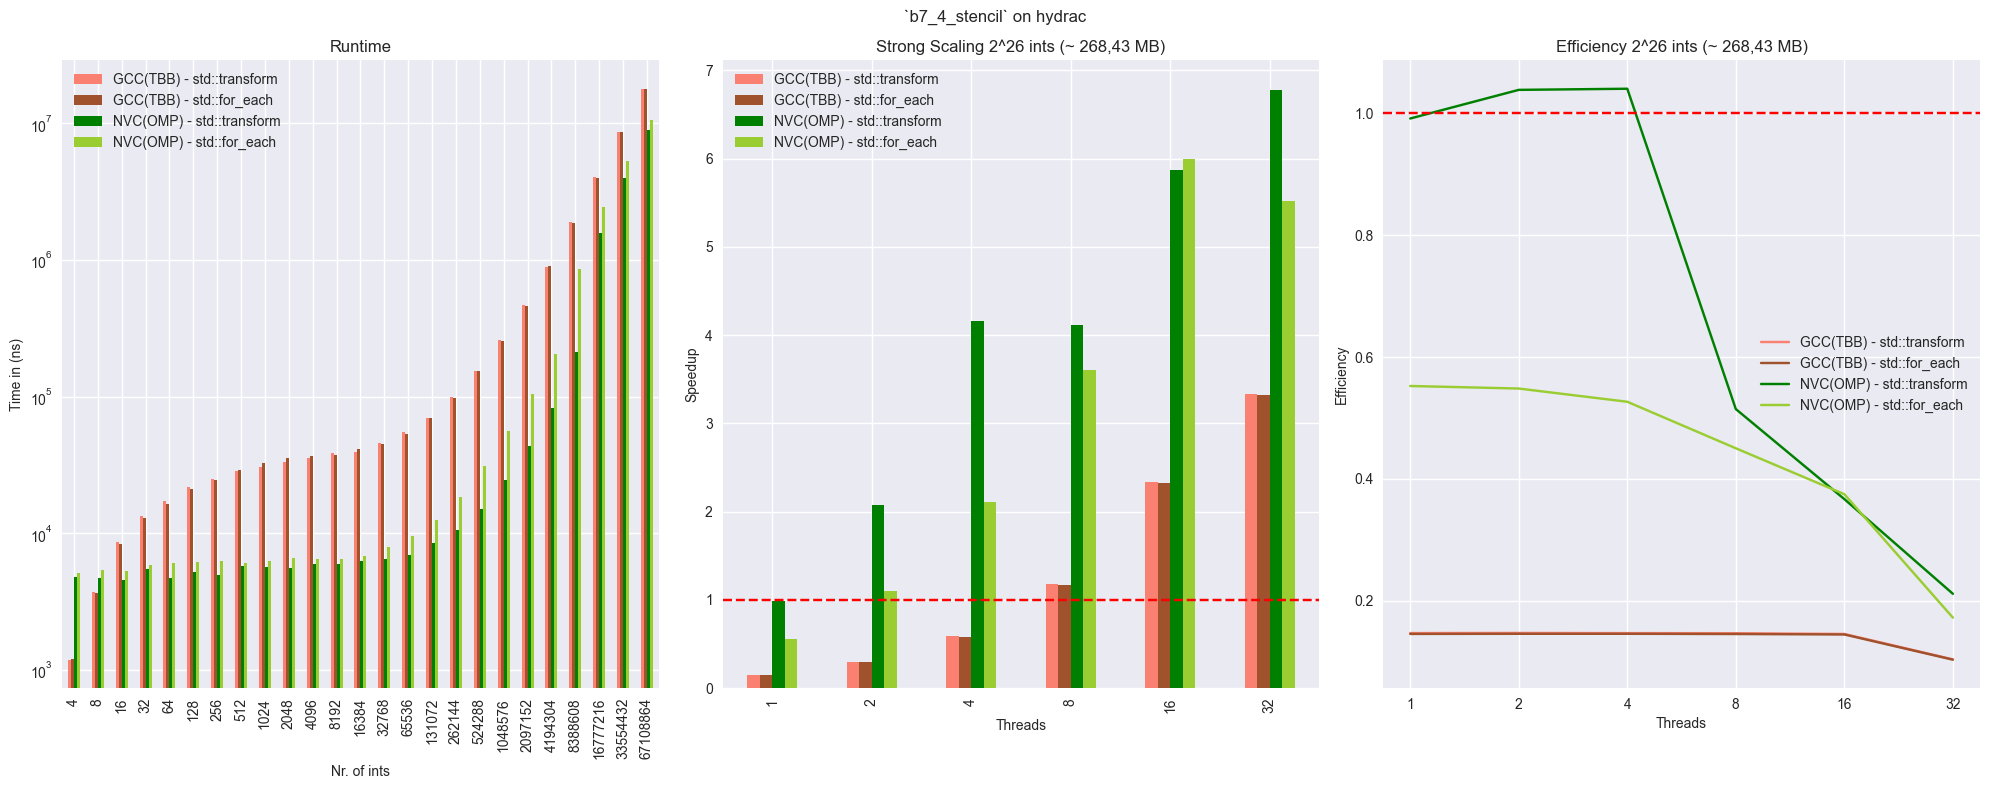

In [177]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_4_stencil_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_4_stencil_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')

#ax_2.set_ylim(0,2.5)



# plot efficiency
ax_3 = b7_4_stencil_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_4_stencil` on {device_name}")

fig.tight_layout()

plot(f"`b7_4_stencil` {device_name}")

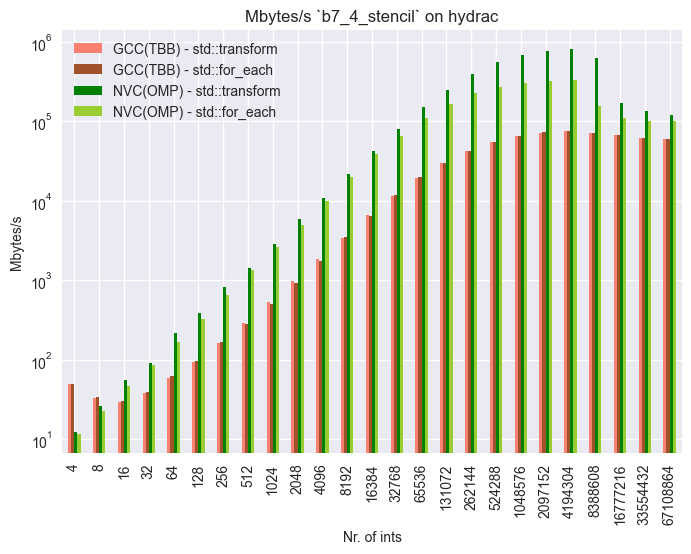

In [178]:

# mbytes graph

b7_4_stencil_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_4_stencil` on {device_name}')


plot(f'`b7_4_stencil` Mbytes_s on {device_name}')

## `b7_5` - Scalar Transform 

In [179]:
benchmark_names = [
    ("b7_5_scalar_transform_number",'std::transform'),
    ("b7_5_scalar_for_each",'std::for_each')
]

strong_scale_base = 'b7_5_scalar_transform_number'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [180]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_5_scalar_transform_time_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_time_merged = pd.merge(b7_5_scalar_transform_time_merged,data[i], on='n')

b7_5_scalar_transform_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,2276.14,4,2310.58,4889.69,5035.82
1,4840.81,8,4904.17,5084.60,5037.12
2,8745.96,16,9181.46,5699.24,5850.06
3,12835.00,32,13358.60,6368.53,6411.44
4,16657.10,64,17053.00,5940.80,5976.80
5,21225.30,128,22324.90,6163.72,6015.87
6,24563.60,256,24860.80,6065.75,5956.45
7,28466.60,512,27974.10,5980.09,6119.28
8,31421.10,1024,32083.50,6148.21,5963.62
9,35328.00,2048,34754.50,6443.97,6312.68


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [181]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_5_scalar_transform_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_strong_scaling_merged = pd.merge(b7_5_scalar_transform_strong_scaling_merged,data[i], on='threads')


b7_5_scalar_transform_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,1.033343,0.610175,0.629798,0.320664
1,2,1.981990,1.229653,1.245565,0.639772
2,4,3.479122,2.198664,2.481033,1.279990
3,8,4.496051,3.172678,4.156614,2.553313
4,16,5.938138,4.146738,7.701841,4.705160
5,32,5.697816,4.030967,9.102152,6.581429


In [182]:
## efficiency graph

b7_5_scalar_transform_efficiency = b7_5_scalar_transform_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] = b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] / b7_5_scalar_transform_efficiency['threads']

b7_5_scalar_transform_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,1.033343,0.610175,0.629798,0.320664
1,2,0.990995,0.614826,0.622782,0.319886
2,4,0.869781,0.549666,0.620258,0.319998
3,8,0.562006,0.396585,0.519577,0.319164
4,16,0.371134,0.259171,0.481365,0.294072
5,32,0.178057,0.125968,0.284442,0.205670


### Mbytes/s

In [183]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_5_scalar_transform_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_bytes_merged = pd.merge(b7_5_scalar_transform_bytes_merged,data[i], on='n')

b7_5_scalar_transform_bytes_merged

,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,14.0589,13.8493,6.54439,6.35447
1,8,13.2209,13.0501,12.58700,12.70570
2,16,14.6353,13.9411,22.45910,21.88010
3,32,19.9454,19.1636,40.19770,39.92870
4,64,30.7376,30.0240,86.18370,85.66460
5,128,48.2443,45.8680,166.13400,170.21600
6,256,83.3754,82.3785,337.63400,343.82900
7,512,143.8880,146.4210,684.94000,669.36000
8,1024,260.7160,255.3340,1332.42000,1373.66000
9,2048,463.7680,471.4200,2542.53000,2595.41000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16668/3247401511.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


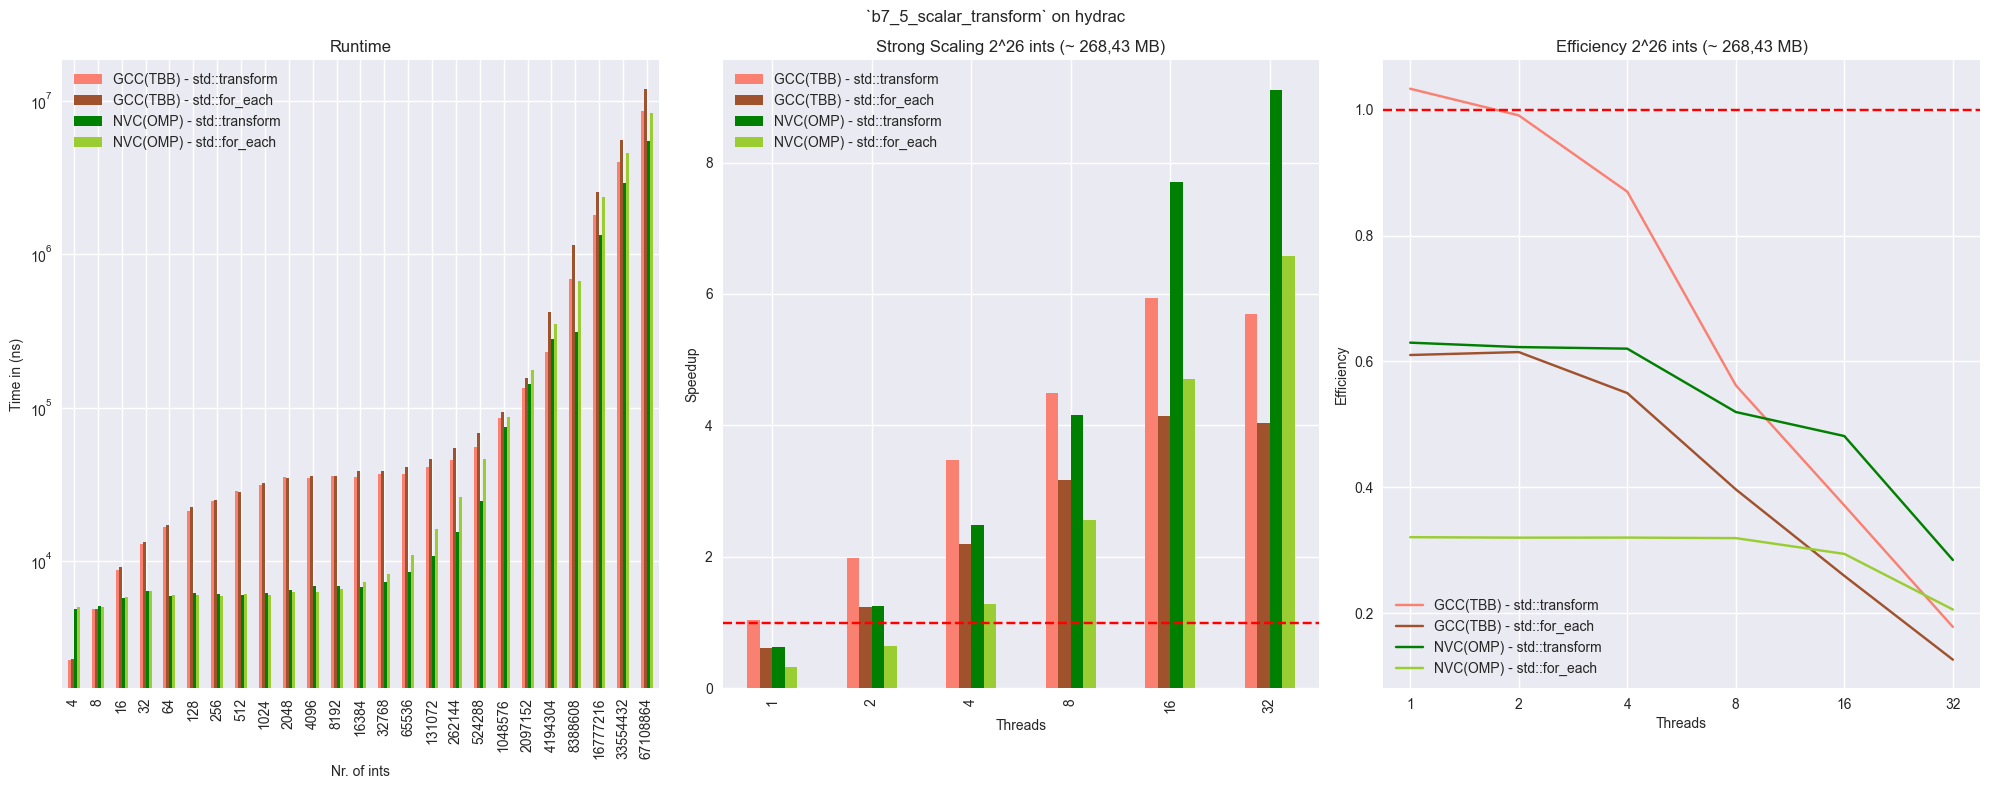

In [184]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_5_scalar_transform_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_5_scalar_transform_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = b7_5_scalar_transform_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_5_scalar_transform` on {device_name}")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` {device_name}")

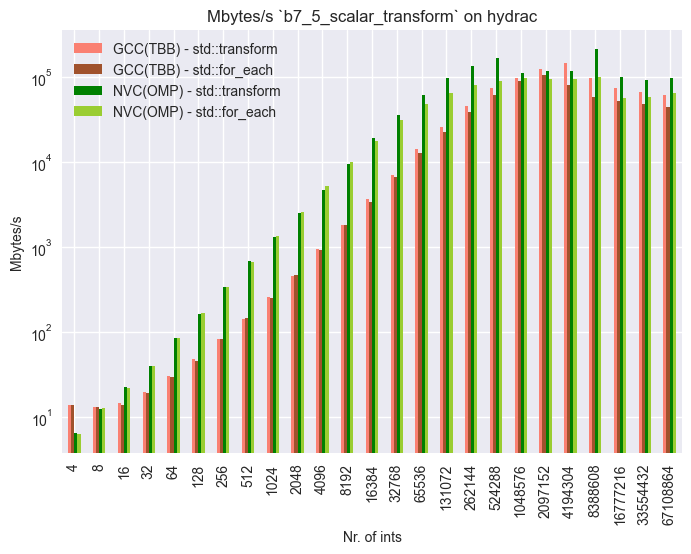

In [185]:

# mbytes graph

b7_5_scalar_transform_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_5_scalar_transform` on {device_name}')


plot(f'`b7_5_scalar_transform` Mbytes_s on {device_name}')

## `b7_6` - Serial vs direct call

In [186]:
benchmark_names = [
    ("b7_6_transform_reduce",'std::transform_reduce'),
    ("b7_6_serial_transform_reduce",'serial')
]

strong_scale_base = 'b7_6_transform_reduce'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [187]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_6_transform_reduce_vs_serial_time_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_time_merged = pd.merge(b7_6_transform_reduce_vs_serial_time_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_time_merged

,GCC(TBB) - std::transform_reduce,n,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1214.62,4,3.900150e+03,10346.9,14972.2
1,2424.47,8,7.738580e+03,10745.7,15308.7
2,4865.24,16,1.417690e+04,10606.7,16279.2
3,8717.61,32,2.322400e+04,11082.4,18386.5
4,12732.20,64,2.999280e+04,11350.7,19323.3
5,15532.20,128,3.985690e+04,11468.1,18728.0
6,19810.80,256,4.642350e+04,11493.2,18969.9
7,23568.60,512,5.418390e+04,11619.4,18267.5
8,26703.20,1024,6.098570e+04,11643.2,18730.0
9,29938.90,2048,6.856350e+04,11643.4,20092.8


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [188]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_6_transform_reduce_vs_serial_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_strong_scaling_merged = pd.merge(b7_6_transform_reduce_vs_serial_strong_scaling_merged,data[i], on='threads')


b7_6_transform_reduce_vs_serial_strong_scaling_merged

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.985522,0.459957,1.439989,0.406624
1,2,1.970893,0.644598,2.760429,0.584791
2,4,3.657283,0.807219,5.218738,0.771237
3,8,6.639417,0.916796,9.871826,0.866383
4,16,10.005388,0.933950,18.770884,0.913363
5,32,12.061769,0.899831,24.275540,0.870291


In [189]:
## efficiency graph

b7_6_transform_reduce_vs_serial_efficiency = b7_6_transform_reduce_vs_serial_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] = b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] / b7_6_transform_reduce_vs_serial_efficiency['threads']

b7_6_transform_reduce_vs_serial_efficiency

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.985522,0.459957,1.439989,0.406624
1,2,0.985447,0.322299,1.380215,0.292396
2,4,0.914321,0.201805,1.304685,0.192809
3,8,0.829927,0.114600,1.233978,0.108298
4,16,0.625337,0.058372,1.173180,0.057085
5,32,0.376930,0.028120,0.758611,0.027197


### Mbytes/s   

In [190]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_6_transform_reduce_vs_serial_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_bytes_merged = pd.merge(b7_6_transform_reduce_vs_serial_bytes_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_bytes_merged

,n,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,4,26.3457,24.6144,3.09272,6.41188
1,8,26.3975,24.8108,5.95585,12.54190
2,16,26.3091,27.0862,12.06780,23.58840
3,32,29.3658,33.0692,23.09970,41.76970
4,64,40.2131,51.2123,45.10750,79.48950
5,128,65.9276,77.0758,89.29150,164.03200
6,256,103.3780,132.3470,178.19200,323.88100
7,512,173.7910,226.7830,352.51300,672.67100
8,1024,306.7790,402.9800,703.58600,1312.12000
9,2048,547.2470,716.8830,1407.15000,2446.24000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_16668/182734503.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


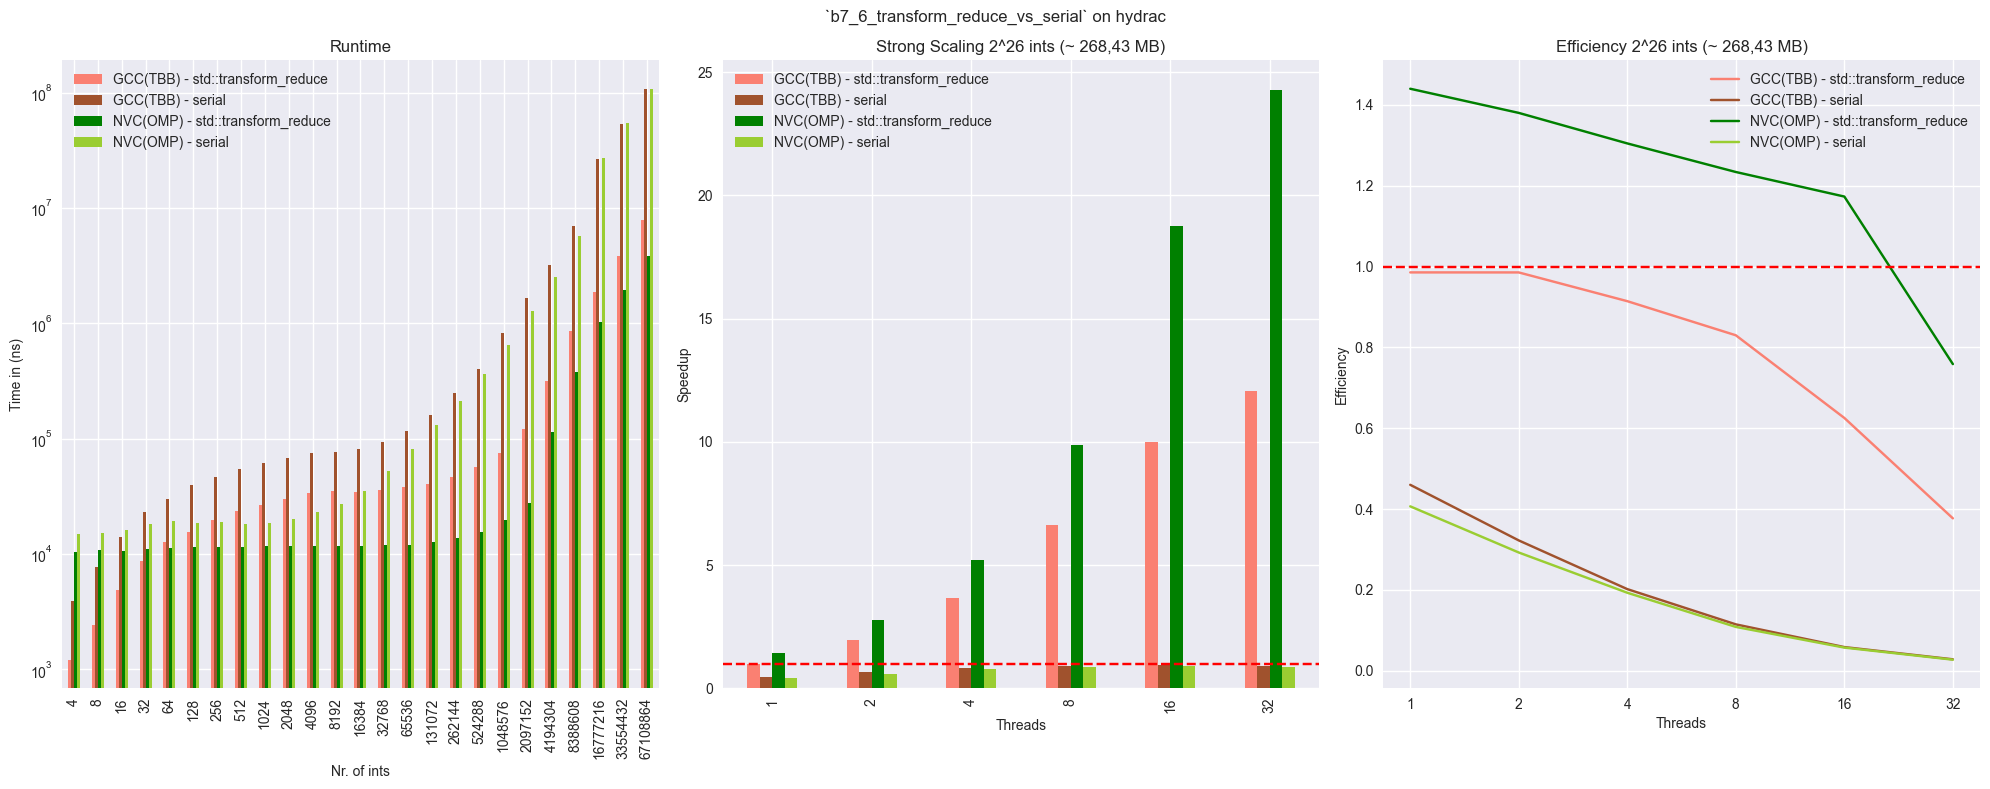

In [191]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_6_transform_reduce_vs_serial_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_6_transform_reduce_vs_serial_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_6_transform_reduce_vs_serial_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_6_transform_reduce_vs_serial` on {device_name}")

fig.tight_layout()

plot(f"`b7_6_transform_reduce_vs_serial` {device_name}")

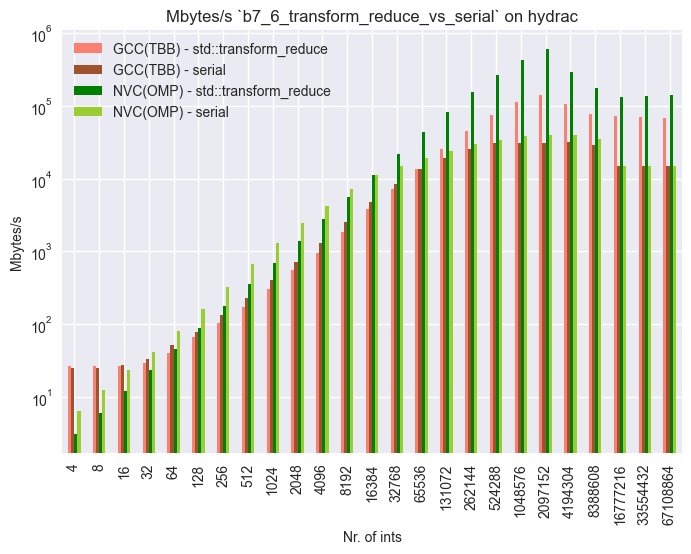

In [192]:
# mbytes graph

b7_6_transform_reduce_vs_serial_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_6_transform_reduce_vs_serial` on {device_name}')


plot(f'`b7_6_transform_reduce_vs_serial` Mbytes_s on {device_name}')

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

Runtime

In [193]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b7_1_copy',b7_1_time_merged, [' - std::copy', ' - std::foreach']),
    
    ('b7_2_all_of_all_true',b7_2_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_first_false',b7_2_first_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_last_false',b7_2_last_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_auto_false',b7_2_auto_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),


    ('b7_3_count_if_all_hit',b7_3_all_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_half_hit',b7_3_half_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_orders_struct',b7_3_orders_struct_time_merged, [' - std::count_if', ' - std::transform_reduce']),

    
    ('b7_4_stencil_transform',b7_4_stencil_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_5_scalar_transform',b7_5_scalar_transform_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_6_transform_reduce',b7_6_transform_reduce_vs_serial_time_merged, [' - std::transform_reduce', ' - serial']),
]


for root_display_name, data_source, suffixes in data_fields:

    for suffix in suffixes:
        entry_dict = {
            'name': [root_display_name + suffix],
        }

        vals = []

        # getting the data from the source for each compiler
        for comp in compilers:
            current_val = int(data_source.iloc[-1][comp + suffix])
            entry_dict[comp] = [current_val]

            vals.append(current_val)

        entry_dict['PP'] = calc_pp(vals)

        other_df = pd.DataFrame.from_dict(entry_dict)
        pp_df = pd.concat([pp_df,other_df],ignore_index=True)



pp_df['Percentage'] = pp_df['PP']

pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')


pp_df_styled = pp_df.style.format({'Percentage': "{:.2%}"})
pp_df_styled

,name,GCC(TBB),NVC(OMP),PP,Percentage,INTERPRET
0,b7_1_copy - std::copy,7074880,11770600,0.750830,75.08%,BAD
1,b7_1_copy - std::foreach,11262400,12797700,0.936189,93.62%,GOOD
2,b7_2_all_of_all_true - std::all_of,2557900,5720660,0.617958,61.80%,BAD
3,b7_2_all_of_all_true - std::transform_reduce,2542980,1967730,0.872470,87.25%,GOOD
4,b7_2_all_of_first_false - std::all_of,9405,114672,0.151599,15.16%,BAD
5,b7_2_all_of_first_false - std::transform_reduce,2536160,4033760,0.772052,77.21%,BAD
6,b7_2_all_of_last_false - std::all_of,2163860,6626910,0.492303,49.23%,BAD
7,b7_2_all_of_last_false - std::transform_reduce,2556680,3152460,0.895645,89.56%,GOOD
8,b7_2_all_of_auto_false - std::all_of,6665,27518,0.389960,39.00%,BAD
9,b7_2_all_of_auto_false - std::transform_reduce,563449,12634,0.043862,4.39%,BAD


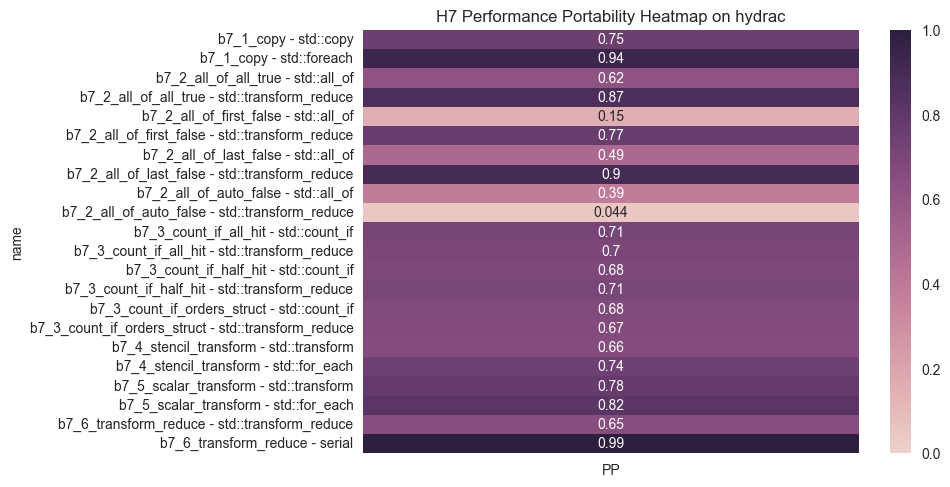

In [194]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','Percentage','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H7 Performance Portability Heatmap on {device_name}')

plot(f'H7 Performance Portability Heatmap on {device_name}')


## Findings for H7

### XXX

### General


### GPU Findings


### Hypothesis Findings


